For viewing individual dataset.

In [4]:
import numpy as np  
import matplotlib.pyplot as plt  
import h5py

In [5]:
# Load h5py file
example_dt = h5py.File('./BraTS2020_training_data/content/data/volume_5_slice_100.h5','r')

In [6]:
# see what is inside that h5 file
print(example_dt.keys())

<KeysViewHDF5 ['image', 'mask']>


In [7]:
image = example_dt['image']
print(image.shape)
mask = example_dt['mask']
print(mask.shape)
mask = np.dstack((np.sum(mask,axis=2)==0,mask))
print(mask.shape)

(240, 240, 4)
(240, 240, 3)
(240, 240, 4)


In [10]:
print(image.dtype)
print(mask.dtype)
print(np.empty(5).dtype)
print(np.empty(5,dtype='uint8').dtype)

float64
uint8
float64
uint8


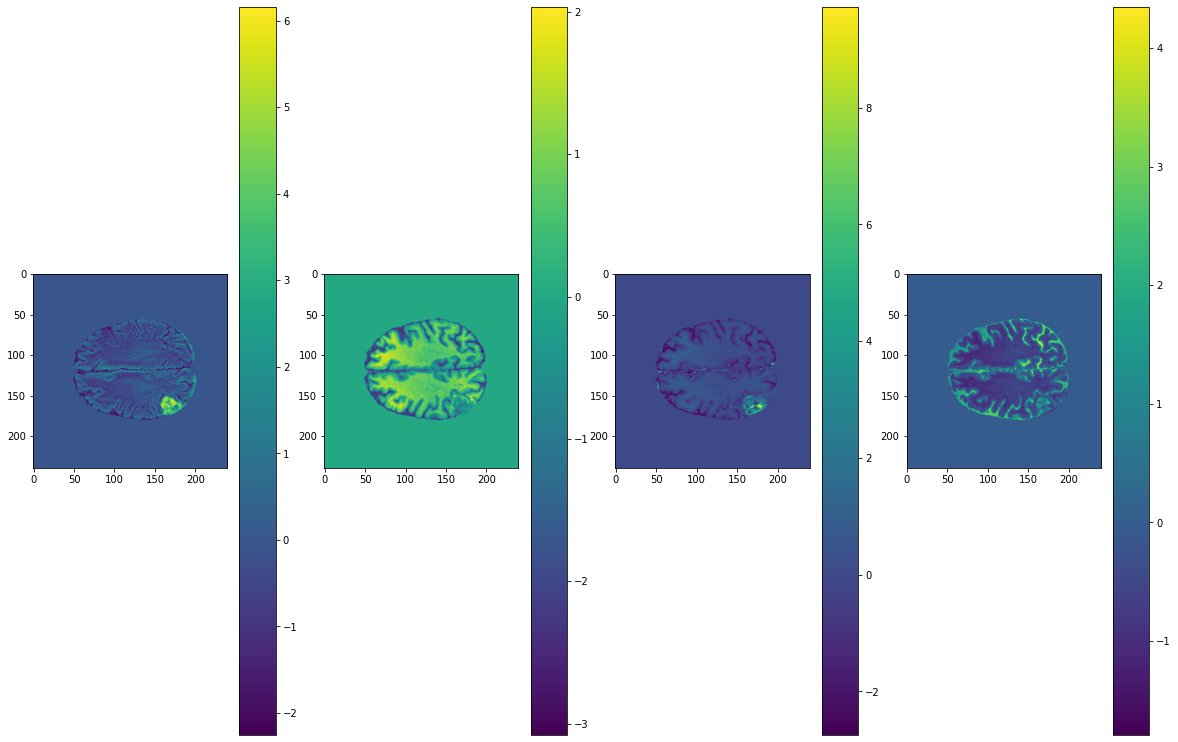

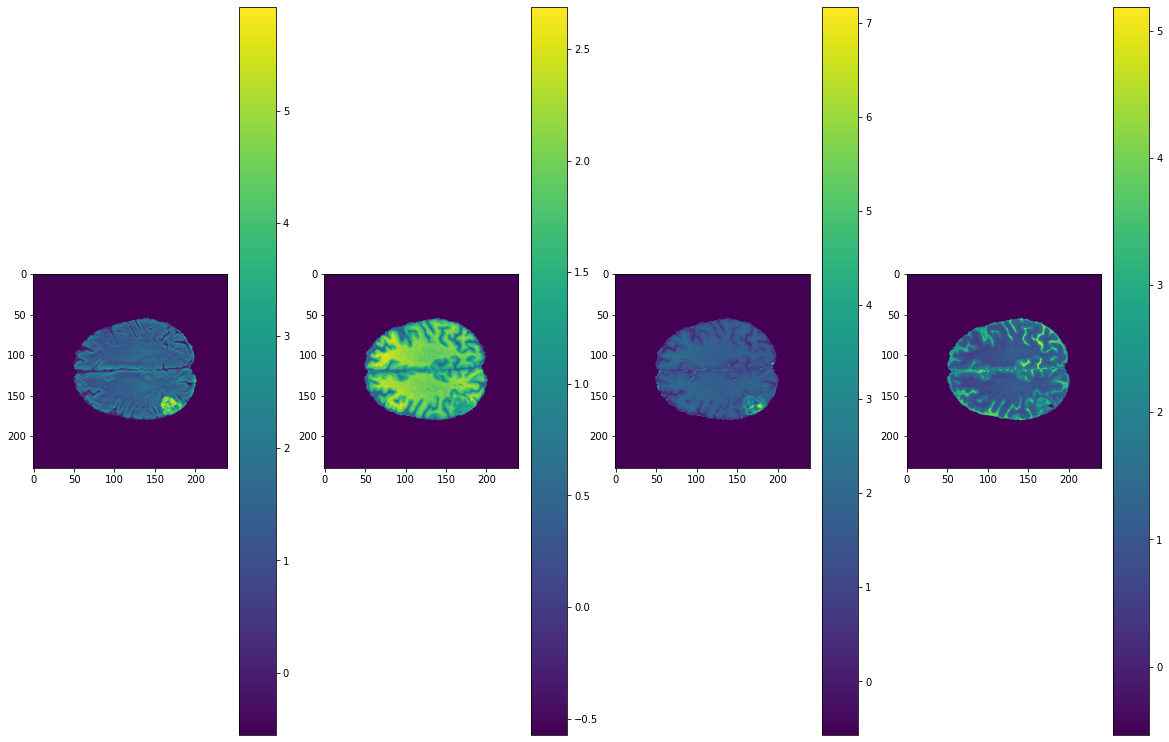

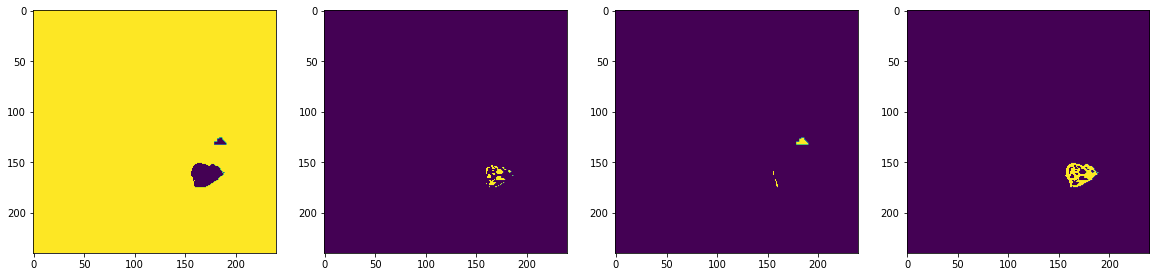

In [118]:
imageNorm = image[()]
imageNorm[imageNorm<0] = np.nan
imageNorm = (imageNorm - np.nanmean(imageNorm,axis=(0,1)))/np.nanstd(imageNorm,axis=(0,1))
imageNorm[np.isnan(imageNorm)]=0
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = imageNorm[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()
"""
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = image[:,:,i]
    img_np[np.nonzero(img_np<0)] = 0
    print(np.mean(img_np[img_np>0]))
    print(np.std(img_np[img_np>0]))
    img_np[img_np>0] = (img_np[img_np>0] - np.mean(img_np[img_np>0]))/np.std(img_np[img_np>0])
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()
"""
plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = image[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
    plt.colorbar()
plt.show()

plt.subplots(1,4,figsize = (20,20))
for i in range(4):
    img_np = mask[:,:,i]
    plt.subplot(1,4,1+i)
    plt.imshow(img_np)
"""
plt.subplot(1,4,4)
img_np = mask[:,:,0] + mask[:,:,1]*2 + mask[:,:,2]*3
plt.imshow(img_np)
"""
plt.show()

Fixed seed for reproducibility (not bootstrapping the test set and keeping it independent). Loads the data and readies the indices for training, validation, test split

lazily loads or loads into RAM, defers normalization to GPU (main dataset class)

In [1]:
import h5py
import gc
import numpy as np
from pathlib import Path
import torch
from torch.utils import data

# taken from https://towardsdatascience.com/hdf5-datasets-for-pytorch-631ff1d750f5

class HDF5Dataset(data.Dataset):
    def __init__(self, file_path, load_ram=False):
        # Search for all h5 files
        self.load_ram = load_ram
        p = Path(file_path)
        assert(p.is_dir())
        self.files = sorted(p.glob('*.h5'))
        if len(self.files) < 1:
            raise RuntimeError('No hdf5 datasets found')
        self.len = len(self.files)
        if load_ram:
            data_path = str(self.files[0].resolve())
            x, y = h5py.File(data_path).items()
            self.data_x = np.empty((self.len,)+x[1][()].shape)
            self.data_y = np.empty((self.len,)+y[1][()].shape,dtype='uint8')
            for index, filepath in enumerate(self.files):
                data_path = str(filepath.resolve())
                x, y = h5py.File(data_path).items()
                self.data_x[index,:,:,:] = torch.from_numpy(x[1][()])
                self.data_y[index,:,:,:] = torch.from_numpy(y[1][()])
            
    def __getitem__(self, index):
        if self.load_ram:
            return (self.data_x[index,:,:,:], self.data_y[index,:,:,:])
        
        # x is image, y is mask
        data_path = str(self.files[index].resolve())
        x, y = h5py.File(data_path).items()
        x = torch.from_numpy(x[1][()])
        y = torch.from_numpy(y[1][()])
        return (x, y)
        #return (x.permute(2,0,1), y.permute(2,0,1))
            
    def __len__(self):
        return self.len

In [2]:
# debug testing the class on a smaller subset
device = torch.device("cuda:0")
subsetTest = HDF5Dataset('./BraTS2020_training_data/content/data/debugSubset',True)

In [3]:
import torchvision

class mriDataAugment(data.Dataset):
    """
    Transforms the training dataset for data augmentation purposes
    """
    def __init__(self, dataset, transform = []):
        self.dataset = dataset
        self.transform = transform
        self.transform_len = len(transform)
        self.data_len = len(self.dataset)
        self.len = (len(transform)+1)*len(self.dataset)
        
    def __getitem__(self, idx):
        data_idx = idx % self.data_len
        trans_idx = idx // self.data_len
        # ensures first image is not transformed
        if trans_idx == 0:
            sample, target = self.dataset[data_idx]
            return sample, target
        else:
            dim_s, dim_t = self.dataset[data_idx][0].shape[2], self.dataset[data_idx][1].shape[2]
            data = torch.cat(self.dataset[data_idx],dim=2)
            data = self.transform[trans_idx-1](data.permute(2,0,1))
            """
            try:
                data = self.transform[trans_idx-1](data.permute(2,0,1))
            except:
                data = data.permute(2,0,1)
                for i in range(data.shape[0]):
                    data[i,:,:] = self.transform[trans_idx-1](data[i,:,:])
            """
            sample, target = torch.split(data,[dim_s,dim_t])
            #target[0,:,:] = torch.sum(target[1:4,:,:],axis=0)==0
            return sample.permute(1,2,0), target.permute(1,2,0)
        
    def __len__(self):
        return self.len

In [4]:
import torchvision
import torchvision.transforms.functional as TF
seedNb = 20985464
totalLen = subsetTest.__len__()
# create 70/15/15 split
trainSz = round(totalLen*0.7)
valSz = round((totalLen-trainSz)/2)
testSz = totalLen-trainSz-valSz
trainSet, valSet, testSet = torch.utils.data.random_split(subsetTest, [trainSz, valSz, testSz], generator=torch.Generator().manual_seed(seedNb))
#transforms=[torchvision.transforms.Lambda(lambda img: TF.adjust_gamma(img,gamma=1))]
#transforms=[torchvision.transforms.RandomPerspective(p=1)]
#trainAugSet = mriDataAugment(trainSet,transforms)
#trainSetLoader = torch.utils.data.DataLoader(trainAugSet, batch_size=32, shuffle=False, pin_memory=True)
trainSetLoader = torch.utils.data.DataLoader(trainSet, batch_size=32, shuffle=True, pin_memory=True)
valSetLoader = torch.utils.data.DataLoader(valSet, batch_size=32, shuffle=False, pin_memory=True)

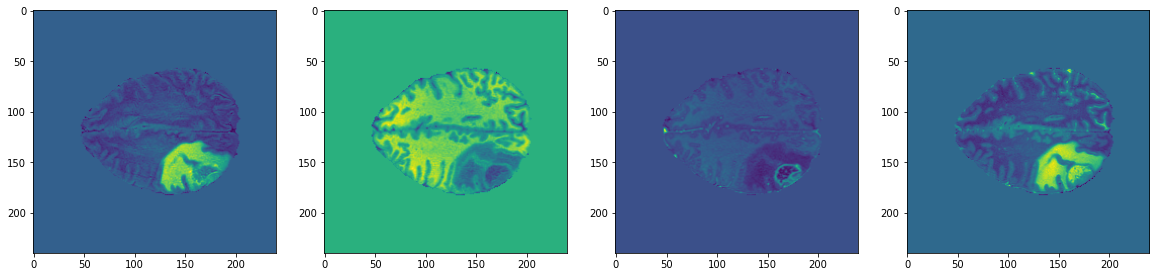

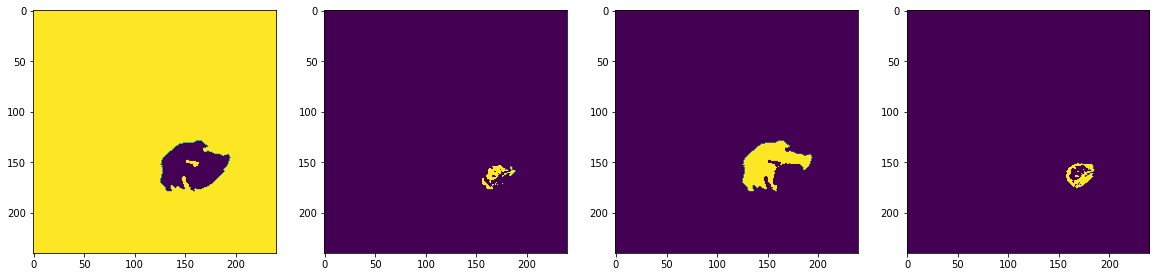

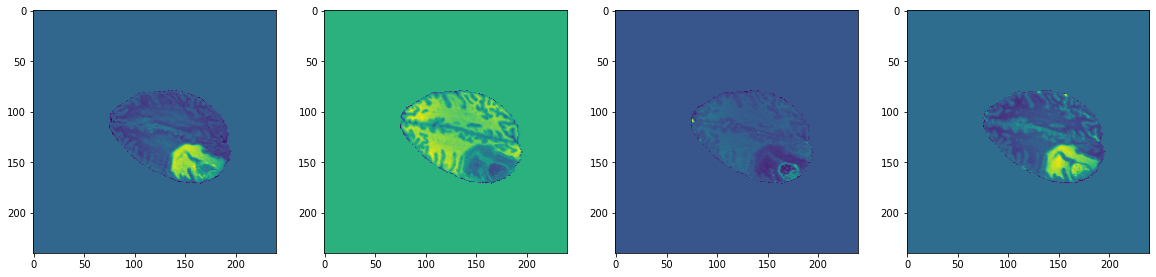

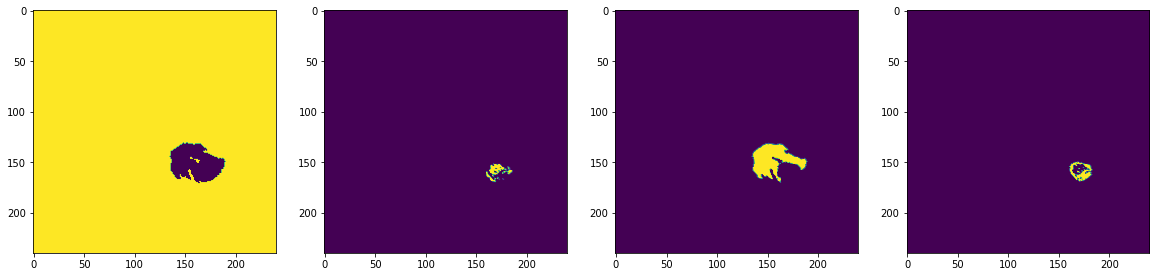

In [130]:
import matplotlib.pyplot as plt

idx=20
idxb=1
idy=(trainSz+idx)%32
idyb=(trainSz+idx)//32+idxb
for batch, (X,y) in enumerate(trainSetLoader):
    if batch==idxb:
        X,y = data_preprocess(X.permute(0,3,1,2).to(memory_format=torch.contiguous_format),
                              y.permute(0,3,1,2).to(memory_format=torch.contiguous_format))
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(X[idx,i,:,:])
        plt.show()
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(y[idx,i,:,:])
        plt.show()
        
    if batch==idyb:
        X,y = data_preprocess(X.permute(0,3,1,2).to(memory_format=torch.contiguous_format),
                              y.permute(0,3,1,2).to(memory_format=torch.contiguous_format))
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(X[idy,i,:,:])
        plt.show()
        plt.subplots(1,4,figsize = (20,20))
        for i in range(4):
            plt.subplot(1,4,1+i)
            plt.imshow(y[idy,i,:,:])
        plt.show()
        break

In [5]:
# unet model from https://github.com/milesial/Pytorch-UNet
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, n_features=16, n_layers=4):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear
        self.n_features = n_features
        self.n_layers = n_layers
        self.downList = nn.ModuleList()
        self.upList = nn.ModuleList()

        self.inc = DoubleConv(n_channels, n_features)
        cntDown = 1
        cntUp = 2**n_layers
        factor = 2 if bilinear else 1
        for i in range(n_layers):
            if i == n_layers-1:
                self.downList.append(Down(n_features*cntDown,n_features*cntDown*2//factor))
                self.upList.append(Up(n_features*2,n_features,bilinear))
            else:
                self.downList.append(Down(n_features*cntDown,n_features*cntDown*2))
                self.upList.append(Up(int(n_features*cntUp),int(n_features*cntUp/2//factor),bilinear))
            cntDown *= 2
            cntUp /= 2
        self.outc = OutConv(n_features, n_classes)

    def forward(self, x):
        xn = []
        xn.append(self.inc(x))
        for i in range(self.n_layers):
            xn.append(self.downList[i](xn[i]))
        for i in range(self.n_layers):
            if i == 0:
                x = self.upList[i](xn[self.n_layers],xn[self.n_layers-1])
            else:
                x = self.upList[i](x,xn[self.n_layers-i-1])
        logits = self.outc(x)
        return logits

In [6]:
device = torch.device("cuda:0")
model = UNet(4,4).to(device)

In [7]:
import torch
from torch import Tensor

# from https://github.com/milesial/Pytorch-UNet

def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)

In [8]:
def data_aug(image,mask,transform):
    # do this before preprocess due to rotation and scaling padding
    if image.dim() == 3:
        data = torch.cat((image,mask))
        dim_i, dim_m = image.shape[0], mask.shape[0]
        data = transform(data)
        image, mask = torch.split(data,[dim_i,dim_m])
    elif image.dim() == 4:
        data = torch.cat((image,mask),dim=1)
        dim_i, dim_m = image.shape[1], mask.shape[1]
        data = transform(data)
        image, mask = torch.split(data,[dim_i,dim_m],dim=1)
    return image, mask

def data_preprocess(image,mask=None):
    # checks if there's a batch dimension
    n_dim = image.dim()
    
    if n_dim == 4:
        # w/ batches BCHW
        norm_axis = (2,3)
        bkgd_axis = 1
    elif n_dim == 3:
        # no batches CHW
        norm_axis = (1,2)
        bkgd_axis = 0
    else:
        raise ValueError(f'Wrong number of dimensions {n_dim}')
    # normalizes data by subtracting mean and dividing by std
    image[image<=0] = float('nan')
    mean = torch.nanmean(image,axis=norm_axis).unsqueeze(2).unsqueeze(2)
    image = (image - mean)/torch.sqrt(torch.nansum((image-mean)**2,axis=norm_axis)/
                                      torch.sum(~torch.isnan(image),axis=norm_axis)).unsqueeze(2).unsqueeze(2)
    image[torch.isnan(image)] = 0
    # adds background mask
    mask = torch.cat(((torch.sum(mask,axis=bkgd_axis)==0).unsqueeze(bkgd_axis),mask),dim=bkgd_axis)    
    """
    if n_dim == 4:
        # w/ batches BHWC
        norm_axis = (1,2)
        bkgd_axis = 3
    elif n_dim == 3:
        # no batches HWC
        norm_axis = (0,1)
        bkgd_axis = 2
    else:
        raise ValueError(f'Wrong number of dimensions {n_dim}')
    
    # normalizes data by subtracting mean and dividing by std
    image[image<=0] = float('nan')
    mean = torch.nanmean(image,axis=norm_axis).unsqueeze(1).unsqueeze(1)
    image = (image - mean)/torch.sqrt(torch.nansum((image-mean)**2,axis=norm_axis)/
                                      torch.sum(~torch.isnan(image),axis=norm_axis)).unsqueeze(1).unsqueeze(1)
    image[torch.isnan(image)] = 0
    if mask == None:
        if n_dim == 4:
            return image.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        return image.permute(2,0,1).to(memory_format=torch.contiguous_format)
    # adds background mask
    mask = torch.cat(((torch.sum(mask,axis=bkgd_axis)==0).unsqueeze(bkgd_axis),mask),dim=bkgd_axis)
    
    if n_dim == 4:
        return image.permute(0,3,1,2).to(memory_format=torch.contiguous_format),mask.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    return image.permute(2,0,1).to(memory_format=torch.contiguous_format), mask.permute(2,0,1).to(memory_format=torch.contiguous_format)
    """
    return image, mask

In [9]:
#import time
def train_loop(dataloader, model, optimizer, grad_scaler,transforms=[]):
    size = len(dataloader.dataset)
    current = 0
    for batch, (X, y) in enumerate(dataloader):
        #t = time.time()
        # Compute prediction and loss
        # Send to GPU first
        X = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        y = y.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
        image, mask = data_preprocess(X,y)
        pred = model(image)
        loss = dice_loss(pred.softmax(1),mask,multiclass=True)
        current += len(image)
        
        # Backpropagation
        optimizer.zero_grad()
        grad_scaler.scale(loss).backward()
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        # for function based data augmentation
        for transform in transforms:
            image, mask = data_aug(X,y,transform)
            image, mask = data_preprocess(image,mask)
            pred = model(image)
            loss = dice_loss(pred.softmax(1),mask,multiclass=True)
            
            # Backpropagation
            optimizer.zero_grad()
            grad_scaler.scale(loss).backward()
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        #if batch % size != 0:
        loss = loss.item()
        #elapsed = time.time() - t
        #print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}] time elapsed: {elapsed:>5f}")
        print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
def test_loop(dataloader, model):
    size = 0
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            image = X.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            mask = y.to(device).float().permute(0,3,1,2).to(memory_format=torch.contiguous_format)
            image, mask = data_preprocess(image,mask)
            pred = model(image)
            test_loss += dice_loss(pred.softmax(1), mask,multiclass=True).item()
            correct += (pred.argmax(1) == mask.argmax(1)).type(torch.float).sum().item()
            size += pred.shape[0]*pred.shape[2]*pred.shape[3]

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [49]:
#optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=1e-8, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240),
           torchvision.transforms.RandomPerspective(p=1)]
#transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240)]

device = torch.device("cuda:0")
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n--------------------")
    train_loop(trainSetLoader,model,optimizer,grad_scaler,transforms)
    test_loop(valSetLoader, model)
print("Done!")
torch.cuda.empty_cache()

Epoch 1
--------------------
loss: 0.897954 [   32/ 1410]
loss: 0.879243 [   64/ 1410]
loss: 0.875383 [   96/ 1410]
loss: 0.882713 [  128/ 1410]
loss: 0.857257 [  160/ 1410]
loss: 0.846534 [  192/ 1410]
loss: 0.829177 [  224/ 1410]
loss: 0.825518 [  256/ 1410]
loss: 0.813403 [  288/ 1410]
loss: 0.817573 [  320/ 1410]
loss: 0.799310 [  352/ 1410]
loss: 0.768865 [  384/ 1410]
loss: 0.762115 [  416/ 1410]
loss: 0.793569 [  448/ 1410]
loss: 0.761569 [  480/ 1410]
loss: 0.758303 [  512/ 1410]
loss: 0.743814 [  544/ 1410]
loss: 0.758273 [  576/ 1410]
loss: 0.743292 [  608/ 1410]
loss: 0.744111 [  640/ 1410]
loss: 0.725820 [  672/ 1410]
loss: 0.666219 [  704/ 1410]
loss: 0.717987 [  736/ 1410]
loss: 0.696452 [  768/ 1410]
loss: 0.672229 [  800/ 1410]
loss: 0.647792 [  832/ 1410]
loss: 0.665566 [  864/ 1410]
loss: 0.612005 [  896/ 1410]
loss: 0.629458 [  928/ 1410]
loss: 0.626028 [  960/ 1410]
loss: 0.523210 [  992/ 1410]
loss: 0.563621 [ 1024/ 1410]
loss: 0.471296 [ 1056/ 1410]
loss: 0.450689

loss: 0.118311 [ 1408/ 1410]
loss: 0.751797 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.152119 

Epoch 7
--------------------
loss: 0.126019 [   32/ 1410]
loss: 0.131040 [   64/ 1410]
loss: 0.112146 [   96/ 1410]
loss: 0.153751 [  128/ 1410]
loss: 0.110994 [  160/ 1410]
loss: 0.128919 [  192/ 1410]
loss: 0.716976 [  224/ 1410]
loss: 0.106236 [  256/ 1410]
loss: 0.116215 [  288/ 1410]
loss: 0.146795 [  320/ 1410]
loss: 0.142773 [  352/ 1410]
loss: 0.435817 [  384/ 1410]
loss: 0.078999 [  416/ 1410]
loss: 0.109467 [  448/ 1410]
loss: 0.094509 [  480/ 1410]
loss: 0.105293 [  512/ 1410]
loss: 0.122274 [  544/ 1410]
loss: 0.138584 [  576/ 1410]
loss: 0.129880 [  608/ 1410]
loss: 0.115144 [  640/ 1410]
loss: 0.182715 [  672/ 1410]
loss: 0.156368 [  704/ 1410]
loss: 0.175703 [  736/ 1410]
loss: 0.160089 [  768/ 1410]
loss: 0.139940 [  800/ 1410]
loss: 0.132695 [  832/ 1410]
loss: 0.115698 [  864/ 1410]
loss: 0.170974 [  896/ 1410]
loss: 0.090190 [  928/ 1410]
loss: 0.499065 [  96

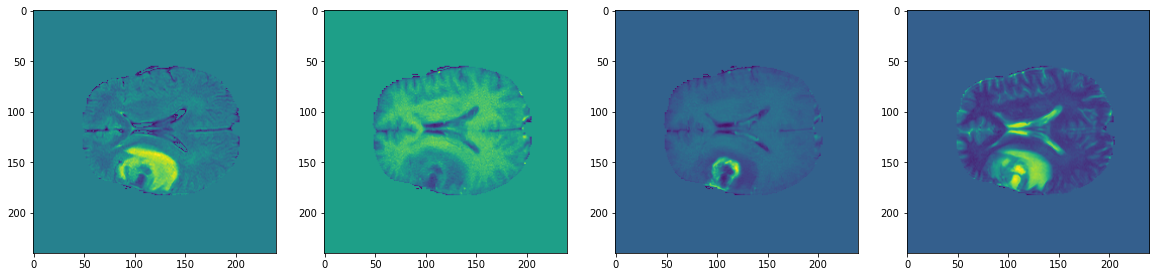

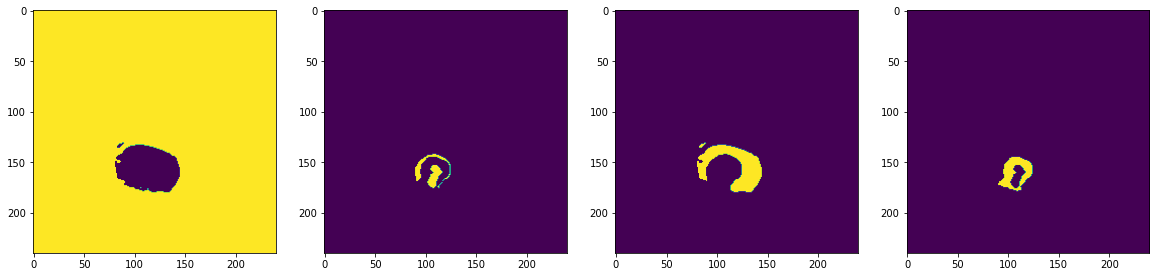

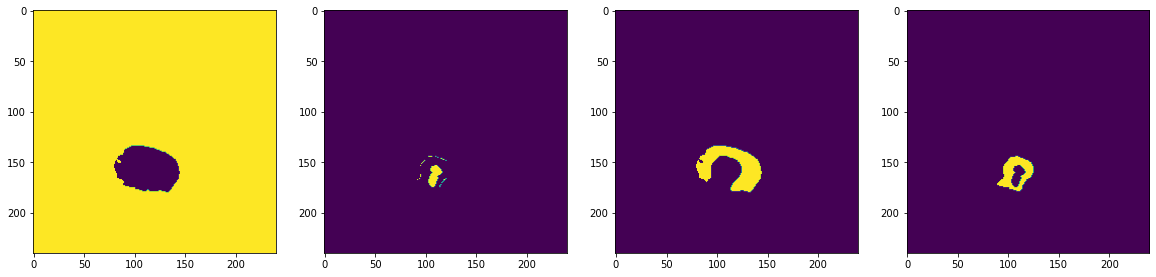

In [50]:
import matplotlib.pyplot as plt
for X, y in valSetLoader:
    image = X.to(device).permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    image = image.float()
    y = y.permute(0,3,1,2).to(memory_format=torch.contiguous_format)
    image,y = data_preprocess(image,y)
    sample = model(image)
    
    sample = sample.argmax(1)
    
    batchidx = 2
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = image[batchidx,i,:,:].cpu().detach().numpy()
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
    
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = sample[batchidx,:,:].cpu().detach().numpy()
        img_np = img_np==i
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
        
    plt.subplots(1,4,figsize = (20,20))
    for i in range(4):
        img_np = y[batchidx,i,:,:].detach().numpy()
        plt.subplot(1,4,1+i)
        plt.imshow(img_np)
    plt.show()
    torch.cuda.empty_cache()
    break

In [10]:
# hyperparameter optimization
import optuna
import torch.optim as optim
import joblib

def objective(trial):

    params = {'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'n_features': trial.suggest_int("n_features", 16, 64),
              'n_layers': trial.suggest_int("n_layers",3,4)}
    
    torch.cuda.empty_cache()
    device = torch.device("cuda:0")
    model = UNet(4,4,bilinear=True,n_features=params["n_features"],n_layers=params["n_layers"]).to(device)
    
    optimizer = getattr(optim, params["optimizer"])(model.parameters(), lr=params['learning_rate'])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=True)
    
    for t in range(epochs):
        print(f"Epoch {t+1}\n--------------------")
        train_loop(trainSetLoader,model,optimizer,grad_scaler,transforms)
        accuracy = test_loop(valSetLoader, model)
        trial.report(accuracy,t)
        
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
    model_str = 'model_weights_trial' + str(trial.number) + '.pth'
    torch.save(model.state_dict(), model_str)
    return accuracy

epochs = 20
device = torch.device("cuda:0")
transforms=[torchvision.transforms.RandomRotation(90),TF.vflip,torchvision.transforms.RandomResizedCrop(240),
           torchvision.transforms.RandomPerspective(p=1)]
study = optuna.create_study(study_name="unet", direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=30, gc_after_trial=True)
joblib.dump(study, "study.pkl")

print("Done!")
torch.cuda.empty_cache()

[I 2022-02-11 10:54:08,651] A new study created in memory with name: unet


Epoch 1
--------------------
loss: 0.894225 [   32/ 1410]
loss: 0.893507 [   64/ 1410]
loss: 0.894744 [   96/ 1410]
loss: 0.895459 [  128/ 1410]
loss: 0.895500 [  160/ 1410]
loss: 0.894320 [  192/ 1410]
loss: 0.895083 [  224/ 1410]
loss: 0.893673 [  256/ 1410]
loss: 0.894976 [  288/ 1410]
loss: 0.894314 [  320/ 1410]
loss: 0.894228 [  352/ 1410]
loss: 0.895397 [  384/ 1410]
loss: 0.893620 [  416/ 1410]
loss: 0.893317 [  448/ 1410]
loss: 0.894455 [  480/ 1410]
loss: 0.893289 [  512/ 1410]
loss: 0.895730 [  544/ 1410]
loss: 0.892476 [  576/ 1410]
loss: 0.895234 [  608/ 1410]
loss: 0.892367 [  640/ 1410]
loss: 0.894667 [  672/ 1410]
loss: 0.893229 [  704/ 1410]
loss: 0.895116 [  736/ 1410]
loss: 0.893478 [  768/ 1410]
loss: 0.894861 [  800/ 1410]
loss: 0.891804 [  832/ 1410]
loss: 0.894524 [  864/ 1410]
loss: 0.893733 [  896/ 1410]
loss: 0.894244 [  928/ 1410]
loss: 0.894388 [  960/ 1410]
loss: 0.895360 [  992/ 1410]
loss: 0.894742 [ 1024/ 1410]
loss: 0.892533 [ 1056/ 1410]
loss: 0.895435

loss: 0.885561 [ 1408/ 1410]
loss: 0.890328 [ 1410/ 1410]
Test Error: 
 Accuracy: 37.4%, Avg loss: 0.881007 

Epoch 7
--------------------
loss: 0.887126 [   32/ 1410]
loss: 0.882830 [   64/ 1410]
loss: 0.885666 [   96/ 1410]
loss: 0.885288 [  128/ 1410]
loss: 0.883460 [  160/ 1410]
loss: 0.885353 [  192/ 1410]
loss: 0.883903 [  224/ 1410]
loss: 0.885024 [  256/ 1410]
loss: 0.885114 [  288/ 1410]
loss: 0.884312 [  320/ 1410]
loss: 0.884276 [  352/ 1410]
loss: 0.886683 [  384/ 1410]
loss: 0.885030 [  416/ 1410]
loss: 0.882671 [  448/ 1410]
loss: 0.885084 [  480/ 1410]
loss: 0.884049 [  512/ 1410]
loss: 0.885158 [  544/ 1410]
loss: 0.884079 [  576/ 1410]
loss: 0.885630 [  608/ 1410]
loss: 0.885133 [  640/ 1410]
loss: 0.882967 [  672/ 1410]
loss: 0.884392 [  704/ 1410]
loss: 0.885440 [  736/ 1410]
loss: 0.884841 [  768/ 1410]
loss: 0.885162 [  800/ 1410]
loss: 0.884958 [  832/ 1410]
loss: 0.884835 [  864/ 1410]
loss: 0.882519 [  896/ 1410]
loss: 0.882367 [  928/ 1410]
loss: 0.885095 [  96

loss: 0.874739 [ 1280/ 1410]
loss: 0.877505 [ 1312/ 1410]
loss: 0.875333 [ 1344/ 1410]
loss: 0.875894 [ 1376/ 1410]
loss: 0.873990 [ 1408/ 1410]
loss: 0.873242 [ 1410/ 1410]
Test Error: 
 Accuracy: 71.9%, Avg loss: 0.871961 

Epoch 13
--------------------
loss: 0.873709 [   32/ 1410]
loss: 0.876782 [   64/ 1410]
loss: 0.878251 [   96/ 1410]
loss: 0.875893 [  128/ 1410]
loss: 0.877658 [  160/ 1410]
loss: 0.875996 [  192/ 1410]
loss: 0.875183 [  224/ 1410]
loss: 0.876932 [  256/ 1410]
loss: 0.875632 [  288/ 1410]
loss: 0.879039 [  320/ 1410]
loss: 0.876823 [  352/ 1410]
loss: 0.874291 [  384/ 1410]
loss: 0.877847 [  416/ 1410]
loss: 0.876109 [  448/ 1410]
loss: 0.876869 [  480/ 1410]
loss: 0.873519 [  512/ 1410]
loss: 0.877108 [  544/ 1410]
loss: 0.876837 [  576/ 1410]
loss: 0.872979 [  608/ 1410]
loss: 0.876757 [  640/ 1410]
loss: 0.874356 [  672/ 1410]
loss: 0.874307 [  704/ 1410]
loss: 0.872439 [  736/ 1410]
loss: 0.877644 [  768/ 1410]
loss: 0.875572 [  800/ 1410]
loss: 0.874124 [  8

loss: 0.867469 [ 1152/ 1410]
loss: 0.869345 [ 1184/ 1410]
loss: 0.869491 [ 1216/ 1410]
loss: 0.868018 [ 1248/ 1410]
loss: 0.872061 [ 1280/ 1410]
loss: 0.867500 [ 1312/ 1410]
loss: 0.870789 [ 1344/ 1410]
loss: 0.869277 [ 1376/ 1410]
loss: 0.868526 [ 1408/ 1410]
loss: 0.869393 [ 1410/ 1410]
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.863984 

Epoch 19
--------------------
loss: 0.870959 [   32/ 1410]
loss: 0.870702 [   64/ 1410]
loss: 0.864738 [   96/ 1410]
loss: 0.870160 [  128/ 1410]
loss: 0.871611 [  160/ 1410]
loss: 0.868250 [  192/ 1410]
loss: 0.868999 [  224/ 1410]
loss: 0.869892 [  256/ 1410]
loss: 0.870393 [  288/ 1410]
loss: 0.865096 [  320/ 1410]
loss: 0.866696 [  352/ 1410]
loss: 0.868973 [  384/ 1410]
loss: 0.865861 [  416/ 1410]
loss: 0.870165 [  448/ 1410]
loss: 0.870661 [  480/ 1410]
loss: 0.867841 [  512/ 1410]
loss: 0.868429 [  544/ 1410]
loss: 0.869281 [  576/ 1410]
loss: 0.870173 [  608/ 1410]
loss: 0.871906 [  640/ 1410]
loss: 0.868741 [  672/ 1410]
loss: 0.866360 [  7

[I 2022-02-11 11:11:24,295] Trial 0 finished with value: 0.8614711582660675 and parameters: {'learning_rate': 0.000218036050604126, 'optimizer': 'SGD', 'n_features': 21, 'n_layers': 3}. Best is trial 0 with value: 0.8614711582660675.


Test Error: 
 Accuracy: 82.7%, Avg loss: 0.861471 

Epoch 1
--------------------
loss: 0.852860 [   32/ 1410]
loss: 0.789935 [   64/ 1410]
loss: 0.696025 [   96/ 1410]
loss: 0.552143 [  128/ 1410]
loss: 0.466029 [  160/ 1410]
loss: 0.460300 [  192/ 1410]
loss: 0.391140 [  224/ 1410]
loss: 0.344262 [  256/ 1410]
loss: 0.341795 [  288/ 1410]
loss: 0.276935 [  320/ 1410]
loss: 0.311211 [  352/ 1410]
loss: 0.330549 [  384/ 1410]
loss: 0.353214 [  416/ 1410]
loss: 0.354281 [  448/ 1410]
loss: 0.347772 [  480/ 1410]
loss: 0.289538 [  512/ 1410]
loss: 0.338159 [  544/ 1410]
loss: 0.272831 [  576/ 1410]
loss: 0.279231 [  608/ 1410]
loss: 0.246631 [  640/ 1410]
loss: 0.282024 [  672/ 1410]
loss: 0.247406 [  704/ 1410]
loss: 0.268583 [  736/ 1410]
loss: 0.283401 [  768/ 1410]
loss: 0.298632 [  800/ 1410]
loss: 0.239449 [  832/ 1410]
loss: 0.357349 [  864/ 1410]
loss: 0.276932 [  896/ 1410]
loss: 0.288910 [  928/ 1410]
loss: 0.336227 [  960/ 1410]
loss: 0.278826 [  992/ 1410]
loss: 0.272820 [ 102

loss: 0.153049 [ 1344/ 1410]
loss: 0.157643 [ 1376/ 1410]
loss: 0.131993 [ 1408/ 1410]
loss: 0.561491 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.190353 

Epoch 7
--------------------
loss: 0.208302 [   32/ 1410]
loss: 0.142641 [   64/ 1410]
loss: 0.139477 [   96/ 1410]
loss: 0.151031 [  128/ 1410]
loss: 0.170180 [  160/ 1410]
loss: 0.172227 [  192/ 1410]
loss: 0.181767 [  224/ 1410]
loss: 0.130318 [  256/ 1410]
loss: 0.169513 [  288/ 1410]
loss: 0.146413 [  320/ 1410]
loss: 0.117445 [  352/ 1410]
loss: 0.152466 [  384/ 1410]
loss: 0.126050 [  416/ 1410]
loss: 0.173002 [  448/ 1410]
loss: 0.144693 [  480/ 1410]
loss: 0.195849 [  512/ 1410]
loss: 0.155058 [  544/ 1410]
loss: 0.127972 [  576/ 1410]
loss: 0.123158 [  608/ 1410]
loss: 0.136072 [  640/ 1410]
loss: 0.205617 [  672/ 1410]
loss: 0.129150 [  704/ 1410]
loss: 0.134105 [  736/ 1410]
loss: 0.141250 [  768/ 1410]
loss: 0.145200 [  800/ 1410]
loss: 0.152119 [  832/ 1410]
loss: 0.235131 [  864/ 1410]
loss: 0.174851 [  89

loss: 0.138090 [ 1216/ 1410]
loss: 0.141832 [ 1248/ 1410]
loss: 0.149774 [ 1280/ 1410]
loss: 0.138852 [ 1312/ 1410]
loss: 0.111481 [ 1344/ 1410]
loss: 0.114848 [ 1376/ 1410]
loss: 0.109524 [ 1408/ 1410]
loss: 0.254200 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.319376 

Epoch 13
--------------------
loss: 0.182281 [   32/ 1410]
loss: 0.163502 [   64/ 1410]
loss: 0.145056 [   96/ 1410]
loss: 0.151021 [  128/ 1410]
loss: 0.142188 [  160/ 1410]
loss: 0.118571 [  192/ 1410]
loss: 0.146953 [  224/ 1410]
loss: 0.163374 [  256/ 1410]
loss: 0.131872 [  288/ 1410]
loss: 0.124630 [  320/ 1410]
loss: 0.163125 [  352/ 1410]
loss: 0.142841 [  384/ 1410]
loss: 0.154900 [  416/ 1410]
loss: 0.128095 [  448/ 1410]
loss: 0.147419 [  480/ 1410]
loss: 0.151662 [  512/ 1410]
loss: 0.200212 [  544/ 1410]
loss: 0.186932 [  576/ 1410]
loss: 0.123207 [  608/ 1410]
loss: 0.156636 [  640/ 1410]
loss: 0.140966 [  672/ 1410]
loss: 0.180556 [  704/ 1410]
loss: 0.139000 [  736/ 1410]
loss: 0.163708 [  7

loss: 0.553517 [ 1088/ 1410]
loss: 0.572739 [ 1120/ 1410]
loss: 0.565909 [ 1152/ 1410]
loss: 0.563308 [ 1184/ 1410]
loss: 0.573734 [ 1216/ 1410]
loss: 0.557276 [ 1248/ 1410]
loss: 0.559676 [ 1280/ 1410]
loss: 0.535715 [ 1312/ 1410]
loss: 0.567921 [ 1344/ 1410]
loss: 0.571172 [ 1376/ 1410]
loss: 0.565267 [ 1408/ 1410]
loss: 0.250121 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.573565 

Epoch 19
--------------------
loss: 0.567390 [   32/ 1410]
loss: 0.565172 [   64/ 1410]
loss: 0.572857 [   96/ 1410]
loss: 0.557824 [  128/ 1410]
loss: 0.553069 [  160/ 1410]
loss: 0.573693 [  192/ 1410]
loss: 0.586284 [  224/ 1410]
loss: 0.569822 [  256/ 1410]
loss: 0.567488 [  288/ 1410]
loss: 0.565594 [  320/ 1410]
loss: 0.552582 [  352/ 1410]
loss: 0.554565 [  384/ 1410]
loss: 0.555373 [  416/ 1410]
loss: 0.577183 [  448/ 1410]
loss: 0.565670 [  480/ 1410]
loss: 0.553664 [  512/ 1410]
loss: 0.580672 [  544/ 1410]
loss: 0.558468 [  576/ 1410]
loss: 0.567361 [  608/ 1410]
loss: 0.564266 [  6

[I 2022-02-11 11:30:16,717] Trial 1 finished with value: 0.5628566145896912 and parameters: {'learning_rate': 0.009468296295778741, 'optimizer': 'Adam', 'n_features': 33, 'n_layers': 3}. Best is trial 1 with value: 0.5628566145896912.


Test Error: 
 Accuracy: 99.2%, Avg loss: 0.562857 

Epoch 1
--------------------
loss: 0.897803 [   32/ 1410]
loss: 0.896244 [   64/ 1410]
loss: 0.894204 [   96/ 1410]
loss: 0.894635 [  128/ 1410]
loss: 0.895041 [  160/ 1410]
loss: 0.897014 [  192/ 1410]
loss: 0.893288 [  224/ 1410]
loss: 0.894070 [  256/ 1410]
loss: 0.892715 [  288/ 1410]
loss: 0.893080 [  320/ 1410]
loss: 0.892540 [  352/ 1410]
loss: 0.892931 [  384/ 1410]
loss: 0.890459 [  416/ 1410]
loss: 0.890705 [  448/ 1410]
loss: 0.890368 [  480/ 1410]
loss: 0.890721 [  512/ 1410]
loss: 0.891176 [  544/ 1410]
loss: 0.891208 [  576/ 1410]
loss: 0.891822 [  608/ 1410]
loss: 0.888612 [  640/ 1410]
loss: 0.890985 [  672/ 1410]
loss: 0.885788 [  704/ 1410]
loss: 0.890210 [  736/ 1410]
loss: 0.889919 [  768/ 1410]
loss: 0.888951 [  800/ 1410]
loss: 0.888182 [  832/ 1410]
loss: 0.886694 [  864/ 1410]
loss: 0.888980 [  896/ 1410]
loss: 0.889162 [  928/ 1410]
loss: 0.889438 [  960/ 1410]
loss: 0.887254 [  992/ 1410]
loss: 0.885860 [ 102

loss: 0.842801 [ 1344/ 1410]
loss: 0.840550 [ 1376/ 1410]
loss: 0.838165 [ 1408/ 1410]
loss: 0.851981 [ 1410/ 1410]
Test Error: 
 Accuracy: 86.8%, Avg loss: 0.833862 

Epoch 7
--------------------
loss: 0.842283 [   32/ 1410]
loss: 0.838245 [   64/ 1410]
loss: 0.836839 [   96/ 1410]
loss: 0.840641 [  128/ 1410]
loss: 0.844494 [  160/ 1410]
loss: 0.836457 [  192/ 1410]
loss: 0.842157 [  224/ 1410]
loss: 0.836990 [  256/ 1410]
loss: 0.840235 [  288/ 1410]
loss: 0.843296 [  320/ 1410]
loss: 0.842225 [  352/ 1410]
loss: 0.842555 [  384/ 1410]
loss: 0.838954 [  416/ 1410]
loss: 0.835413 [  448/ 1410]
loss: 0.834964 [  480/ 1410]
loss: 0.827626 [  512/ 1410]
loss: 0.834562 [  544/ 1410]
loss: 0.838891 [  576/ 1410]
loss: 0.832144 [  608/ 1410]
loss: 0.840459 [  640/ 1410]
loss: 0.836691 [  672/ 1410]
loss: 0.832351 [  704/ 1410]
loss: 0.826923 [  736/ 1410]
loss: 0.831882 [  768/ 1410]
loss: 0.839116 [  800/ 1410]
loss: 0.838836 [  832/ 1410]
loss: 0.831511 [  864/ 1410]
loss: 0.835508 [  89

loss: 0.784113 [ 1216/ 1410]
loss: 0.781516 [ 1248/ 1410]
loss: 0.788631 [ 1280/ 1410]
loss: 0.784250 [ 1312/ 1410]
loss: 0.780462 [ 1344/ 1410]
loss: 0.793810 [ 1376/ 1410]
loss: 0.773732 [ 1408/ 1410]
loss: 0.793573 [ 1410/ 1410]
Test Error: 
 Accuracy: 93.0%, Avg loss: 0.769937 

Epoch 13
--------------------
loss: 0.790110 [   32/ 1410]
loss: 0.780912 [   64/ 1410]
loss: 0.779496 [   96/ 1410]
loss: 0.784245 [  128/ 1410]
loss: 0.791586 [  160/ 1410]
loss: 0.784405 [  192/ 1410]
loss: 0.778574 [  224/ 1410]
loss: 0.784632 [  256/ 1410]
loss: 0.768997 [  288/ 1410]
loss: 0.778013 [  320/ 1410]
loss: 0.781113 [  352/ 1410]
loss: 0.790506 [  384/ 1410]
loss: 0.775299 [  416/ 1410]
loss: 0.781440 [  448/ 1410]
loss: 0.789344 [  480/ 1410]
loss: 0.780024 [  512/ 1410]
loss: 0.781726 [  544/ 1410]
loss: 0.799979 [  576/ 1410]
loss: 0.776585 [  608/ 1410]
loss: 0.789950 [  640/ 1410]
loss: 0.783581 [  672/ 1410]
loss: 0.788564 [  704/ 1410]
loss: 0.768231 [  736/ 1410]
loss: 0.780649 [  7

loss: 0.719382 [ 1088/ 1410]
loss: 0.739672 [ 1120/ 1410]
loss: 0.743844 [ 1152/ 1410]
loss: 0.723876 [ 1184/ 1410]
loss: 0.734232 [ 1216/ 1410]
loss: 0.731606 [ 1248/ 1410]
loss: 0.742465 [ 1280/ 1410]
loss: 0.730285 [ 1312/ 1410]
loss: 0.712442 [ 1344/ 1410]
loss: 0.722462 [ 1376/ 1410]
loss: 0.707863 [ 1408/ 1410]
loss: 0.659021 [ 1410/ 1410]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.694999 

Epoch 19
--------------------
loss: 0.737984 [   32/ 1410]
loss: 0.723297 [   64/ 1410]
loss: 0.732940 [   96/ 1410]
loss: 0.729337 [  128/ 1410]
loss: 0.694877 [  160/ 1410]
loss: 0.740089 [  192/ 1410]
loss: 0.724102 [  224/ 1410]
loss: 0.706527 [  256/ 1410]
loss: 0.727124 [  288/ 1410]
loss: 0.725186 [  320/ 1410]
loss: 0.710054 [  352/ 1410]
loss: 0.740062 [  384/ 1410]
loss: 0.734335 [  416/ 1410]
loss: 0.743377 [  448/ 1410]
loss: 0.713931 [  480/ 1410]
loss: 0.697481 [  512/ 1410]
loss: 0.745199 [  544/ 1410]
loss: 0.734508 [  576/ 1410]
loss: 0.730948 [  608/ 1410]
loss: 0.710160 [  6

[I 2022-02-11 11:47:59,484] Trial 2 finished with value: 0.6514853775501251 and parameters: {'learning_rate': 0.002475339671305894, 'optimizer': 'SGD', 'n_features': 21, 'n_layers': 4}. Best is trial 1 with value: 0.5628566145896912.


Test Error: 
 Accuracy: 99.1%, Avg loss: 0.651485 

Epoch 1
--------------------
loss: 0.887387 [   32/ 1410]
loss: 0.885548 [   64/ 1410]
loss: 0.883269 [   96/ 1410]
loss: 0.881917 [  128/ 1410]
loss: 0.880502 [  160/ 1410]
loss: 0.880561 [  192/ 1410]
loss: 0.878864 [  224/ 1410]
loss: 0.877015 [  256/ 1410]
loss: 0.874137 [  288/ 1410]
loss: 0.871677 [  320/ 1410]
loss: 0.873023 [  352/ 1410]
loss: 0.874993 [  384/ 1410]
loss: 0.869122 [  416/ 1410]
loss: 0.871940 [  448/ 1410]
loss: 0.869705 [  480/ 1410]
loss: 0.870355 [  512/ 1410]
loss: 0.869868 [  544/ 1410]
loss: 0.870081 [  576/ 1410]
loss: 0.867240 [  608/ 1410]
loss: 0.861033 [  640/ 1410]
loss: 0.863425 [  672/ 1410]
loss: 0.860593 [  704/ 1410]
loss: 0.862934 [  736/ 1410]
loss: 0.860243 [  768/ 1410]
loss: 0.858443 [  800/ 1410]
loss: 0.854396 [  832/ 1410]
loss: 0.854221 [  864/ 1410]
loss: 0.855576 [  896/ 1410]
loss: 0.851677 [  928/ 1410]
loss: 0.852861 [  960/ 1410]
loss: 0.846194 [  992/ 1410]
loss: 0.843129 [ 102

loss: 0.227704 [ 1344/ 1410]
loss: 0.345776 [ 1376/ 1410]
loss: 0.251662 [ 1408/ 1410]
loss: 0.177709 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.340457 

Epoch 7
--------------------
loss: 0.278187 [   32/ 1410]
loss: 0.254777 [   64/ 1410]
loss: 0.296114 [   96/ 1410]
loss: 0.228742 [  128/ 1410]
loss: 0.278493 [  160/ 1410]
loss: 0.216840 [  192/ 1410]
loss: 0.276451 [  224/ 1410]
loss: 0.329974 [  256/ 1410]
loss: 0.218895 [  288/ 1410]
loss: 0.218645 [  320/ 1410]
loss: 0.291884 [  352/ 1410]
loss: 0.214769 [  384/ 1410]
loss: 0.197423 [  416/ 1410]
loss: 0.424623 [  448/ 1410]
loss: 0.222950 [  480/ 1410]
loss: 0.220428 [  512/ 1410]
loss: 0.266660 [  544/ 1410]
loss: 0.225271 [  576/ 1410]
loss: 0.355228 [  608/ 1410]
loss: 0.207911 [  640/ 1410]
loss: 0.252011 [  672/ 1410]
loss: 0.189213 [  704/ 1410]
loss: 0.213475 [  736/ 1410]
loss: 0.393947 [  768/ 1410]
loss: 0.241432 [  800/ 1410]
loss: 0.271582 [  832/ 1410]
loss: 0.209239 [  864/ 1410]
loss: 0.194767 [  89

loss: 0.129866 [ 1216/ 1410]
loss: 0.122172 [ 1248/ 1410]
loss: 0.146795 [ 1280/ 1410]
loss: 0.125408 [ 1312/ 1410]
loss: 0.114699 [ 1344/ 1410]
loss: 0.110955 [ 1376/ 1410]
loss: 0.162983 [ 1408/ 1410]
loss: 0.489577 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.205233 

Epoch 13
--------------------
loss: 0.117927 [   32/ 1410]
loss: 0.136747 [   64/ 1410]
loss: 0.120527 [   96/ 1410]
loss: 0.120273 [  128/ 1410]
loss: 0.110706 [  160/ 1410]
loss: 0.112601 [  192/ 1410]
loss: 0.131019 [  224/ 1410]
loss: 0.146974 [  256/ 1410]
loss: 0.166272 [  288/ 1410]
loss: 0.140815 [  320/ 1410]
loss: 0.142717 [  352/ 1410]
loss: 0.113278 [  384/ 1410]
loss: 0.124637 [  416/ 1410]
loss: 0.367870 [  448/ 1410]
loss: 0.147978 [  480/ 1410]
loss: 0.128241 [  512/ 1410]
loss: 0.123088 [  544/ 1410]
loss: 0.133031 [  576/ 1410]
loss: 0.108343 [  608/ 1410]
loss: 0.112231 [  640/ 1410]
loss: 0.108690 [  672/ 1410]
loss: 0.123557 [  704/ 1410]
loss: 0.159727 [  736/ 1410]
loss: 0.095002 [  7

loss: 0.113787 [ 1088/ 1410]
loss: 0.117796 [ 1120/ 1410]
loss: 0.092831 [ 1152/ 1410]
loss: 0.098241 [ 1184/ 1410]
loss: 0.130095 [ 1216/ 1410]
loss: 0.126855 [ 1248/ 1410]
loss: 0.126785 [ 1280/ 1410]
loss: 0.120744 [ 1312/ 1410]
loss: 0.112440 [ 1344/ 1410]
loss: 0.105076 [ 1376/ 1410]
loss: 0.100712 [ 1408/ 1410]
loss: 0.750528 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.131651 

Epoch 19
--------------------
loss: 0.124930 [   32/ 1410]
loss: 0.088002 [   64/ 1410]
loss: 0.123795 [   96/ 1410]
loss: 0.123576 [  128/ 1410]
loss: 0.121011 [  160/ 1410]
loss: 0.101520 [  192/ 1410]
loss: 0.105767 [  224/ 1410]
loss: 0.111280 [  256/ 1410]
loss: 0.104377 [  288/ 1410]
loss: 0.140747 [  320/ 1410]
loss: 0.081086 [  352/ 1410]
loss: 0.116765 [  384/ 1410]
loss: 0.107553 [  416/ 1410]
loss: 0.247281 [  448/ 1410]
loss: 0.093364 [  480/ 1410]
loss: 0.114902 [  512/ 1410]
loss: 0.110125 [  544/ 1410]
loss: 0.123049 [  576/ 1410]
loss: 0.111795 [  608/ 1410]
loss: 0.122653 [  6

[I 2022-02-11 12:01:55,434] Trial 3 finished with value: 0.13944512605667114 and parameters: {'learning_rate': 0.008174957435824757, 'optimizer': 'SGD', 'n_features': 31, 'n_layers': 3}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.139445 

Epoch 1
--------------------
loss: 0.910726 [   32/ 1410]
loss: 0.911889 [   64/ 1410]
loss: 0.909587 [   96/ 1410]
loss: 0.911533 [  128/ 1410]
loss: 0.910388 [  160/ 1410]
loss: 0.909689 [  192/ 1410]
loss: 0.909879 [  224/ 1410]
loss: 0.908348 [  256/ 1410]
loss: 0.909063 [  288/ 1410]
loss: 0.910189 [  320/ 1410]
loss: 0.909920 [  352/ 1410]
loss: 0.909673 [  384/ 1410]
loss: 0.910951 [  416/ 1410]
loss: 0.909823 [  448/ 1410]
loss: 0.908962 [  480/ 1410]
loss: 0.908425 [  512/ 1410]
loss: 0.906490 [  544/ 1410]
loss: 0.909032 [  576/ 1410]
loss: 0.909672 [  608/ 1410]
loss: 0.908881 [  640/ 1410]
loss: 0.909132 [  672/ 1410]
loss: 0.908723 [  704/ 1410]
loss: 0.909381 [  736/ 1410]
loss: 0.908420 [  768/ 1410]
loss: 0.909507 [  800/ 1410]
loss: 0.910230 [  832/ 1410]
loss: 0.910011 [  864/ 1410]
loss: 0.908194 [  896/ 1410]
loss: 0.908524 [  928/ 1410]
loss: 0.907552 [  960/ 1410]
loss: 0.909376 [  992/ 1410]
loss: 0.907960 [ 102

loss: 0.903460 [ 1344/ 1410]
loss: 0.903585 [ 1376/ 1410]
loss: 0.903968 [ 1408/ 1410]
loss: 0.903184 [ 1410/ 1410]
Test Error: 
 Accuracy: 0.9%, Avg loss: 0.902838 

Epoch 7
--------------------
loss: 0.902624 [   32/ 1410]
loss: 0.904976 [   64/ 1410]
loss: 0.905146 [   96/ 1410]
loss: 0.903422 [  128/ 1410]
loss: 0.903223 [  160/ 1410]
loss: 0.903923 [  192/ 1410]
loss: 0.904789 [  224/ 1410]
loss: 0.903507 [  256/ 1410]
loss: 0.903535 [  288/ 1410]
loss: 0.900644 [  320/ 1410]
loss: 0.904620 [  352/ 1410]
loss: 0.903779 [  384/ 1410]
loss: 0.904107 [  416/ 1410]
loss: 0.905280 [  448/ 1410]
loss: 0.904497 [  480/ 1410]
loss: 0.902449 [  512/ 1410]
loss: 0.900103 [  544/ 1410]
loss: 0.905246 [  576/ 1410]
loss: 0.903720 [  608/ 1410]
loss: 0.902188 [  640/ 1410]
loss: 0.904382 [  672/ 1410]
loss: 0.902897 [  704/ 1410]
loss: 0.902704 [  736/ 1410]
loss: 0.905125 [  768/ 1410]
loss: 0.902531 [  800/ 1410]
loss: 0.903953 [  832/ 1410]
loss: 0.903295 [  864/ 1410]
loss: 0.904544 [  896

loss: 0.900485 [ 1216/ 1410]
loss: 0.900556 [ 1248/ 1410]
loss: 0.899096 [ 1280/ 1410]
loss: 0.899162 [ 1312/ 1410]
loss: 0.897732 [ 1344/ 1410]
loss: 0.900028 [ 1376/ 1410]
loss: 0.898031 [ 1408/ 1410]
loss: 0.890480 [ 1410/ 1410]
Test Error: 
 Accuracy: 1.3%, Avg loss: 0.897107 

Epoch 13
--------------------
loss: 0.898338 [   32/ 1410]
loss: 0.900727 [   64/ 1410]
loss: 0.899823 [   96/ 1410]
loss: 0.900272 [  128/ 1410]
loss: 0.898289 [  160/ 1410]
loss: 0.898570 [  192/ 1410]
loss: 0.899902 [  224/ 1410]
loss: 0.895558 [  256/ 1410]
loss: 0.898040 [  288/ 1410]
loss: 0.897471 [  320/ 1410]
loss: 0.900079 [  352/ 1410]
loss: 0.896647 [  384/ 1410]
loss: 0.897587 [  416/ 1410]
loss: 0.898625 [  448/ 1410]
loss: 0.900746 [  480/ 1410]
loss: 0.898666 [  512/ 1410]
loss: 0.896891 [  544/ 1410]
loss: 0.900462 [  576/ 1410]
loss: 0.898499 [  608/ 1410]
loss: 0.898117 [  640/ 1410]
loss: 0.898386 [  672/ 1410]
loss: 0.892265 [  704/ 1410]
loss: 0.899017 [  736/ 1410]
loss: 0.899959 [  76

loss: 0.897115 [ 1088/ 1410]
loss: 0.894887 [ 1120/ 1410]
loss: 0.895558 [ 1152/ 1410]
loss: 0.892640 [ 1184/ 1410]
loss: 0.895328 [ 1216/ 1410]
loss: 0.896255 [ 1248/ 1410]
loss: 0.895559 [ 1280/ 1410]
loss: 0.893536 [ 1312/ 1410]
loss: 0.894637 [ 1344/ 1410]
loss: 0.893892 [ 1376/ 1410]
loss: 0.893546 [ 1408/ 1410]
loss: 0.891349 [ 1410/ 1410]
Test Error: 
 Accuracy: 3.2%, Avg loss: 0.892263 

Epoch 19
--------------------
loss: 0.893500 [   32/ 1410]
loss: 0.894421 [   64/ 1410]
loss: 0.894500 [   96/ 1410]
loss: 0.892714 [  128/ 1410]
loss: 0.893752 [  160/ 1410]
loss: 0.893959 [  192/ 1410]
loss: 0.894235 [  224/ 1410]
loss: 0.894505 [  256/ 1410]
loss: 0.892989 [  288/ 1410]
loss: 0.894530 [  320/ 1410]
loss: 0.893232 [  352/ 1410]
loss: 0.894903 [  384/ 1410]
loss: 0.895564 [  416/ 1410]
loss: 0.895058 [  448/ 1410]
loss: 0.892856 [  480/ 1410]
loss: 0.894710 [  512/ 1410]
loss: 0.897270 [  544/ 1410]
loss: 0.895873 [  576/ 1410]
loss: 0.892880 [  608/ 1410]
loss: 0.893157 [  64

[I 2022-02-11 12:14:17,834] Trial 4 finished with value: 0.8907077133655548 and parameters: {'learning_rate': 0.00017655514335293185, 'optimizer': 'SGD', 'n_features': 24, 'n_layers': 4}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 6.0%, Avg loss: 0.890708 

Epoch 1
--------------------
loss: 0.860284 [   32/ 1410]
loss: 0.817493 [   64/ 1410]
loss: 0.810236 [   96/ 1410]
loss: 0.792943 [  128/ 1410]
loss: 0.794798 [  160/ 1410]
loss: 0.776764 [  192/ 1410]
loss: 0.798428 [  224/ 1410]
loss: 0.785504 [  256/ 1410]
loss: 0.786984 [  288/ 1410]
loss: 0.775537 [  320/ 1410]
loss: 0.767777 [  352/ 1410]
loss: 0.762458 [  384/ 1410]
loss: 0.773421 [  416/ 1410]
loss: 0.762661 [  448/ 1410]
loss: 0.742999 [  480/ 1410]
loss: 0.769276 [  512/ 1410]
loss: 0.765836 [  544/ 1410]
loss: 0.734737 [  576/ 1410]
loss: 0.755641 [  608/ 1410]
loss: 0.748434 [  640/ 1410]
loss: 0.719551 [  672/ 1410]
loss: 0.728097 [  704/ 1410]
loss: 0.726407 [  736/ 1410]
loss: 0.718270 [  768/ 1410]
loss: 0.757637 [  800/ 1410]
loss: 0.711968 [  832/ 1410]
loss: 0.712843 [  864/ 1410]
loss: 0.715308 [  896/ 1410]
loss: 0.699892 [  928/ 1410]
loss: 0.704839 [  960/ 1410]
loss: 0.717511 [  992/ 1410]
loss: 0.700185 [ 1024

loss: 0.109264 [ 1344/ 1410]
loss: 0.144712 [ 1376/ 1410]
loss: 0.127983 [ 1408/ 1410]
loss: 0.751086 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.151900 

Epoch 7
--------------------
loss: 0.111169 [   32/ 1410]
loss: 0.108089 [   64/ 1410]
loss: 0.115420 [   96/ 1410]
loss: 0.142619 [  128/ 1410]
loss: 0.126363 [  160/ 1410]
loss: 0.097097 [  192/ 1410]
loss: 0.111404 [  224/ 1410]
loss: 0.116853 [  256/ 1410]
loss: 0.079589 [  288/ 1410]
loss: 0.175391 [  320/ 1410]
loss: 0.127483 [  352/ 1410]
loss: 0.122687 [  384/ 1410]
loss: 0.093173 [  416/ 1410]
loss: 0.111236 [  448/ 1410]
loss: 0.155381 [  480/ 1410]
loss: 0.169503 [  512/ 1410]
loss: 0.103797 [  544/ 1410]
loss: 0.105504 [  576/ 1410]
loss: 0.131521 [  608/ 1410]
loss: 0.111793 [  640/ 1410]
loss: 0.125232 [  672/ 1410]
loss: 0.086575 [  704/ 1410]
loss: 0.108561 [  736/ 1410]
loss: 0.110574 [  768/ 1410]
loss: 0.135284 [  800/ 1410]
loss: 0.103282 [  832/ 1410]
loss: 0.105148 [  864/ 1410]
loss: 0.116768 [  89

loss: 0.123565 [ 1216/ 1410]
loss: 0.125686 [ 1248/ 1410]
loss: 0.109124 [ 1280/ 1410]
loss: 0.084779 [ 1312/ 1410]
loss: 0.105959 [ 1344/ 1410]
loss: 0.096829 [ 1376/ 1410]
loss: 0.100944 [ 1408/ 1410]
loss: 0.332388 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.364002 

Epoch 13
--------------------
loss: 0.128811 [   32/ 1410]
loss: 0.086668 [   64/ 1410]
loss: 0.105735 [   96/ 1410]
loss: 0.109184 [  128/ 1410]
loss: 0.094972 [  160/ 1410]
loss: 0.114854 [  192/ 1410]
loss: 0.088322 [  224/ 1410]
loss: 0.101258 [  256/ 1410]
loss: 0.102696 [  288/ 1410]
loss: 0.106309 [  320/ 1410]
loss: 0.088962 [  352/ 1410]
loss: 0.105088 [  384/ 1410]
loss: 0.098426 [  416/ 1410]
loss: 0.146478 [  448/ 1410]
loss: 0.072168 [  480/ 1410]
loss: 0.088489 [  512/ 1410]
loss: 0.103313 [  544/ 1410]
loss: 0.094650 [  576/ 1410]
loss: 0.105363 [  608/ 1410]
loss: 0.109330 [  640/ 1410]
loss: 0.119518 [  672/ 1410]
loss: 0.101867 [  704/ 1410]
loss: 0.112219 [  736/ 1410]
loss: 0.121808 [  7

loss: 0.080929 [ 1088/ 1410]
loss: 0.118500 [ 1120/ 1410]
loss: 0.101451 [ 1152/ 1410]
loss: 0.084404 [ 1184/ 1410]
loss: 0.084599 [ 1216/ 1410]
loss: 0.127942 [ 1248/ 1410]
loss: 0.092784 [ 1280/ 1410]
loss: 0.144125 [ 1312/ 1410]
loss: 0.103626 [ 1344/ 1410]
loss: 0.078486 [ 1376/ 1410]
loss: 0.111231 [ 1408/ 1410]
loss: 0.157206 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.145226 

Epoch 19
--------------------
loss: 0.099196 [   32/ 1410]
loss: 0.079475 [   64/ 1410]
loss: 0.207620 [   96/ 1410]
loss: 0.112450 [  128/ 1410]
loss: 0.086086 [  160/ 1410]
loss: 0.107453 [  192/ 1410]
loss: 0.078328 [  224/ 1410]
loss: 0.095814 [  256/ 1410]
loss: 0.117945 [  288/ 1410]
loss: 0.091108 [  320/ 1410]
loss: 0.120868 [  352/ 1410]
loss: 0.078570 [  384/ 1410]
loss: 0.103953 [  416/ 1410]
loss: 0.131518 [  448/ 1410]
loss: 0.113601 [  480/ 1410]
loss: 0.107104 [  512/ 1410]
loss: 0.093199 [  544/ 1410]
loss: 0.083182 [  576/ 1410]
loss: 0.093970 [  608/ 1410]
loss: 0.101455 [  6

[I 2022-02-11 12:36:13,609] Trial 5 finished with value: 0.21609876155853272 and parameters: {'learning_rate': 0.00031385981683110985, 'optimizer': 'RMSprop', 'n_features': 41, 'n_layers': 3}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.216099 

Epoch 1
--------------------
loss: 0.867973 [   32/ 1410]
loss: 0.850976 [   64/ 1410]
loss: 0.841355 [   96/ 1410]
loss: 0.833606 [  128/ 1410]
loss: 0.835182 [  160/ 1410]
loss: 0.828483 [  192/ 1410]
loss: 0.825698 [  224/ 1410]
loss: 0.828501 [  256/ 1410]
loss: 0.814304 [  288/ 1410]
loss: 0.816721 [  320/ 1410]
loss: 0.817417 [  352/ 1410]
loss: 0.817117 [  384/ 1410]
loss: 0.807297 [  416/ 1410]
loss: 0.808385 [  448/ 1410]
loss: 0.806035 [  480/ 1410]
loss: 0.803844 [  512/ 1410]
loss: 0.812033 [  544/ 1410]
loss: 0.802522 [  576/ 1410]
loss: 0.805311 [  608/ 1410]
loss: 0.800231 [  640/ 1410]
loss: 0.792220 [  672/ 1410]
loss: 0.794117 [  704/ 1410]
loss: 0.798895 [  736/ 1410]
loss: 0.805473 [  768/ 1410]
loss: 0.791155 [  800/ 1410]
loss: 0.796934 [  832/ 1410]
loss: 0.796341 [  864/ 1410]
loss: 0.797027 [  896/ 1410]
loss: 0.775988 [  928/ 1410]
loss: 0.792691 [  960/ 1410]
loss: 0.789698 [  992/ 1410]
loss: 0.786788 [ 102

loss: 0.268565 [ 1344/ 1410]
loss: 0.166652 [ 1376/ 1410]
loss: 0.266684 [ 1408/ 1410]
loss: 0.539030 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.249902 

Epoch 7
--------------------
loss: 0.218752 [   32/ 1410]
loss: 0.187300 [   64/ 1410]
loss: 0.169254 [   96/ 1410]
loss: 0.233822 [  128/ 1410]
loss: 0.164244 [  160/ 1410]
loss: 0.191078 [  192/ 1410]
loss: 0.182509 [  224/ 1410]
loss: 0.195088 [  256/ 1410]
loss: 0.146844 [  288/ 1410]
loss: 0.137470 [  320/ 1410]
loss: 0.166187 [  352/ 1410]
loss: 0.149782 [  384/ 1410]
loss: 0.129872 [  416/ 1410]
loss: 0.163846 [  448/ 1410]
loss: 0.110132 [  480/ 1410]
loss: 0.189742 [  512/ 1410]
loss: 0.124942 [  544/ 1410]
loss: 0.134432 [  576/ 1410]
loss: 0.170604 [  608/ 1410]
loss: 0.146267 [  640/ 1410]
loss: 0.119117 [  672/ 1410]
loss: 0.135169 [  704/ 1410]
loss: 0.165346 [  736/ 1410]
loss: 0.141785 [  768/ 1410]
loss: 0.214572 [  800/ 1410]
loss: 0.146073 [  832/ 1410]
loss: 0.155781 [  864/ 1410]
loss: 0.152379 [  89

loss: 0.129729 [ 1216/ 1410]
loss: 0.088743 [ 1248/ 1410]
loss: 0.118419 [ 1280/ 1410]
loss: 0.100400 [ 1312/ 1410]
loss: 0.116444 [ 1344/ 1410]
loss: 0.140767 [ 1376/ 1410]
loss: 0.134364 [ 1408/ 1410]
loss: 0.750519 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.151390 

Epoch 13
--------------------
loss: 0.113546 [   32/ 1410]
loss: 0.097979 [   64/ 1410]
loss: 0.098949 [   96/ 1410]
loss: 0.128110 [  128/ 1410]
loss: 0.078955 [  160/ 1410]
loss: 0.085487 [  192/ 1410]
loss: 0.089747 [  224/ 1410]
loss: 0.119114 [  256/ 1410]
loss: 0.112088 [  288/ 1410]
loss: 0.107261 [  320/ 1410]
loss: 0.105918 [  352/ 1410]
loss: 0.079893 [  384/ 1410]
loss: 0.098893 [  416/ 1410]
loss: 0.118717 [  448/ 1410]
loss: 0.124845 [  480/ 1410]
loss: 0.100477 [  512/ 1410]
loss: 0.094712 [  544/ 1410]
loss: 0.107091 [  576/ 1410]
loss: 0.083695 [  608/ 1410]
loss: 0.112304 [  640/ 1410]
loss: 0.102146 [  672/ 1410]
loss: 0.120197 [  704/ 1410]
loss: 0.159389 [  736/ 1410]
loss: 0.089009 [  7

loss: 0.108332 [ 1088/ 1410]
loss: 0.084632 [ 1120/ 1410]
loss: 0.087777 [ 1152/ 1410]
loss: 0.094420 [ 1184/ 1410]
loss: 0.105212 [ 1216/ 1410]
loss: 0.088375 [ 1248/ 1410]
loss: 0.094819 [ 1280/ 1410]
loss: 0.095939 [ 1312/ 1410]
loss: 0.093551 [ 1344/ 1410]
loss: 0.082453 [ 1376/ 1410]
loss: 0.074550 [ 1408/ 1410]
loss: 0.472114 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.158705 

Epoch 19
--------------------
loss: 0.099171 [   32/ 1410]
loss: 0.121096 [   64/ 1410]
loss: 0.115878 [   96/ 1410]
loss: 0.093097 [  128/ 1410]
loss: 0.099120 [  160/ 1410]
loss: 0.088904 [  192/ 1410]
loss: 0.097086 [  224/ 1410]
loss: 0.096275 [  256/ 1410]
loss: 0.090561 [  288/ 1410]
loss: 0.070603 [  320/ 1410]
loss: 0.085832 [  352/ 1410]
loss: 0.092678 [  384/ 1410]
loss: 0.092669 [  416/ 1410]
loss: 0.075811 [  448/ 1410]
loss: 0.095594 [  480/ 1410]
loss: 0.078192 [  512/ 1410]
loss: 0.105657 [  544/ 1410]
loss: 0.120107 [  576/ 1410]
loss: 0.098927 [  608/ 1410]
loss: 0.088643 [  6

[I 2022-02-11 12:55:35,773] Trial 6 finished with value: 0.25326341986656187 and parameters: {'learning_rate': 0.00014186489893828816, 'optimizer': 'RMSprop', 'n_features': 35, 'n_layers': 3}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 99.5%, Avg loss: 0.253263 

Epoch 1
--------------------
loss: 0.831137 [   32/ 1410]
loss: 0.765907 [   64/ 1410]
loss: 0.585501 [   96/ 1410]
loss: 0.458930 [  128/ 1410]
loss: 0.306483 [  160/ 1410]
loss: 0.313069 [  192/ 1410]
loss: 0.278800 [  224/ 1410]
loss: 0.274804 [  256/ 1410]
loss: 0.260845 [  288/ 1410]
loss: 0.296576 [  320/ 1410]
loss: 0.283313 [  352/ 1410]
loss: 0.298969 [  384/ 1410]
loss: 0.229259 [  416/ 1410]
loss: 0.294630 [  448/ 1410]
loss: 0.255205 [  480/ 1410]
loss: 0.241383 [  512/ 1410]
loss: 0.318887 [  544/ 1410]
loss: 0.206511 [  576/ 1410]
loss: 0.286441 [  608/ 1410]
loss: 0.264842 [  640/ 1410]
loss: 0.246196 [  672/ 1410]
loss: 0.248178 [  704/ 1410]
loss: 0.244066 [  736/ 1410]
loss: 0.261217 [  768/ 1410]
loss: 0.223048 [  800/ 1410]
loss: 0.228410 [  832/ 1410]
loss: 0.358613 [  864/ 1410]
loss: 0.353727 [  896/ 1410]
loss: 0.277928 [  928/ 1410]
loss: 0.292699 [  960/ 1410]
loss: 0.374939 [  992/ 1410]
loss: 0.287182 [ 102

loss: 0.134118 [ 1344/ 1410]
loss: 0.170018 [ 1376/ 1410]
loss: 0.174399 [ 1408/ 1410]
loss: 0.246828 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.169760 

Epoch 7
--------------------
loss: 0.149970 [   32/ 1410]
loss: 0.246898 [   64/ 1410]
loss: 0.172168 [   96/ 1410]
loss: 0.156258 [  128/ 1410]
loss: 0.192116 [  160/ 1410]
loss: 0.148152 [  192/ 1410]
loss: 0.192270 [  224/ 1410]
loss: 0.159585 [  256/ 1410]
loss: 0.180856 [  288/ 1410]
loss: 0.167305 [  320/ 1410]
loss: 0.186325 [  352/ 1410]
loss: 0.155688 [  384/ 1410]
loss: 0.147453 [  416/ 1410]
loss: 0.165260 [  448/ 1410]
loss: 0.174618 [  480/ 1410]
loss: 0.173574 [  512/ 1410]
loss: 0.151211 [  544/ 1410]
loss: 0.141483 [  576/ 1410]
loss: 0.133092 [  608/ 1410]
loss: 0.161825 [  640/ 1410]
loss: 0.149181 [  672/ 1410]
loss: 0.131401 [  704/ 1410]
loss: 0.155879 [  736/ 1410]
loss: 0.184521 [  768/ 1410]
loss: 0.162608 [  800/ 1410]
loss: 0.195498 [  832/ 1410]
loss: 0.174470 [  864/ 1410]
loss: 0.165444 [  89

loss: 0.138601 [ 1216/ 1410]
loss: 0.149187 [ 1248/ 1410]
loss: 0.135241 [ 1280/ 1410]
loss: 0.155618 [ 1312/ 1410]
loss: 0.123256 [ 1344/ 1410]
loss: 0.162704 [ 1376/ 1410]
loss: 0.129958 [ 1408/ 1410]
loss: 0.750591 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.156935 

Epoch 13
--------------------
loss: 0.105784 [   32/ 1410]
loss: 0.141863 [   64/ 1410]
loss: 0.150400 [   96/ 1410]
loss: 0.138113 [  128/ 1410]
loss: 0.105668 [  160/ 1410]
loss: 0.096923 [  192/ 1410]
loss: 0.151940 [  224/ 1410]
loss: 0.160311 [  256/ 1410]
loss: 0.116840 [  288/ 1410]
loss: 0.117672 [  320/ 1410]
loss: 0.220310 [  352/ 1410]
loss: 0.097764 [  384/ 1410]
loss: 0.121429 [  416/ 1410]
loss: 0.211640 [  448/ 1410]
loss: 0.132696 [  480/ 1410]
loss: 0.099917 [  512/ 1410]
loss: 0.115761 [  544/ 1410]
loss: 0.126868 [  576/ 1410]
loss: 0.136676 [  608/ 1410]
loss: 0.160088 [  640/ 1410]
loss: 0.219805 [  672/ 1410]
loss: 0.136193 [  704/ 1410]
loss: 0.151255 [  736/ 1410]
loss: 0.126196 [  7

loss: 0.112356 [ 1088/ 1410]
loss: 0.134143 [ 1120/ 1410]
loss: 0.119486 [ 1152/ 1410]
loss: 0.135923 [ 1184/ 1410]
loss: 0.112419 [ 1216/ 1410]
loss: 0.111054 [ 1248/ 1410]
loss: 0.136537 [ 1280/ 1410]
loss: 0.091419 [ 1312/ 1410]
loss: 0.166585 [ 1344/ 1410]
loss: 0.137025 [ 1376/ 1410]
loss: 0.123748 [ 1408/ 1410]
loss: 0.329101 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.138750 

Epoch 19
--------------------
loss: 0.113948 [   32/ 1410]
loss: 0.133540 [   64/ 1410]
loss: 0.128717 [   96/ 1410]
loss: 0.117908 [  128/ 1410]
loss: 0.119988 [  160/ 1410]
loss: 0.129545 [  192/ 1410]
loss: 0.154039 [  224/ 1410]
loss: 0.114761 [  256/ 1410]
loss: 0.138219 [  288/ 1410]
loss: 0.108369 [  320/ 1410]
loss: 0.134384 [  352/ 1410]
loss: 0.103265 [  384/ 1410]
loss: 0.113809 [  416/ 1410]
loss: 0.135584 [  448/ 1410]
loss: 0.097527 [  480/ 1410]
loss: 0.158002 [  512/ 1410]
loss: 0.130145 [  544/ 1410]
loss: 0.129975 [  576/ 1410]
loss: 0.126118 [  608/ 1410]
loss: 0.207416 [  6

[I 2022-02-11 13:25:00,263] Trial 7 finished with value: 0.16792381405830384 and parameters: {'learning_rate': 0.006951355714651223, 'optimizer': 'Adam', 'n_features': 55, 'n_layers': 3}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.167924 

Epoch 1
--------------------
loss: 0.887208 [   32/ 1410]
loss: 0.884909 [   64/ 1410]
loss: 0.885113 [   96/ 1410]
loss: 0.883431 [  128/ 1410]
loss: 0.883739 [  160/ 1410]
loss: 0.882433 [  192/ 1410]
loss: 0.881119 [  224/ 1410]
loss: 0.880115 [  256/ 1410]
loss: 0.876867 [  288/ 1410]
loss: 0.875629 [  320/ 1410]
loss: 0.876243 [  352/ 1410]
loss: 0.875001 [  384/ 1410]
loss: 0.873648 [  416/ 1410]
loss: 0.869328 [  448/ 1410]
loss: 0.870427 [  480/ 1410]
loss: 0.872758 [  512/ 1410]
loss: 0.867176 [  544/ 1410]
loss: 0.866972 [  576/ 1410]
loss: 0.867096 [  608/ 1410]
loss: 0.862702 [  640/ 1410]
loss: 0.859214 [  672/ 1410]
loss: 0.862663 [  704/ 1410]
loss: 0.867965 [  736/ 1410]
loss: 0.854370 [  768/ 1410]
loss: 0.859498 [  800/ 1410]
loss: 0.854507 [  832/ 1410]
loss: 0.859424 [  864/ 1410]
loss: 0.857014 [  896/ 1410]
loss: 0.858316 [  928/ 1410]
loss: 0.856594 [  960/ 1410]
loss: 0.851795 [  992/ 1410]
loss: 0.851659 [ 102

[I 2022-02-11 13:26:07,739] Trial 8 pruned. 


Test Error: 
 Accuracy: 91.9%, Avg loss: 0.824517 

Epoch 1
--------------------
loss: 0.901206 [   32/ 1410]
loss: 0.895719 [   64/ 1410]
loss: 0.890751 [   96/ 1410]
loss: 0.886246 [  128/ 1410]
loss: 0.885159 [  160/ 1410]
loss: 0.880542 [  192/ 1410]
loss: 0.875961 [  224/ 1410]
loss: 0.869006 [  256/ 1410]
loss: 0.872431 [  288/ 1410]
loss: 0.870828 [  320/ 1410]
loss: 0.869350 [  352/ 1410]
loss: 0.870225 [  384/ 1410]
loss: 0.868436 [  416/ 1410]
loss: 0.866715 [  448/ 1410]
loss: 0.863741 [  480/ 1410]
loss: 0.860039 [  512/ 1410]
loss: 0.866487 [  544/ 1410]
loss: 0.863587 [  576/ 1410]
loss: 0.863330 [  608/ 1410]
loss: 0.860190 [  640/ 1410]
loss: 0.862745 [  672/ 1410]
loss: 0.858534 [  704/ 1410]
loss: 0.856617 [  736/ 1410]
loss: 0.852063 [  768/ 1410]
loss: 0.855092 [  800/ 1410]
loss: 0.851397 [  832/ 1410]
loss: 0.858304 [  864/ 1410]
loss: 0.848344 [  896/ 1410]
loss: 0.857038 [  928/ 1410]
loss: 0.848493 [  960/ 1410]
loss: 0.851416 [  992/ 1410]
loss: 0.853559 [ 102

[I 2022-02-11 13:26:48,565] Trial 9 pruned. 


Test Error: 
 Accuracy: 88.4%, Avg loss: 0.827568 

Epoch 1
--------------------
loss: 0.879861 [   32/ 1410]
loss: 0.863428 [   64/ 1410]
loss: 0.839901 [   96/ 1410]
loss: 0.830535 [  128/ 1410]
loss: 0.822737 [  160/ 1410]
loss: 0.793330 [  192/ 1410]
loss: 0.795523 [  224/ 1410]
loss: 0.783479 [  256/ 1410]
loss: 0.767950 [  288/ 1410]
loss: 0.764033 [  320/ 1410]
loss: 0.748641 [  352/ 1410]
loss: 0.746199 [  384/ 1410]
loss: 0.750004 [  416/ 1410]
loss: 0.701706 [  448/ 1410]
loss: 0.702585 [  480/ 1410]
loss: 0.668332 [  512/ 1410]
loss: 0.670936 [  544/ 1410]
loss: 0.591570 [  576/ 1410]
loss: 0.560964 [  608/ 1410]
loss: 0.575140 [  640/ 1410]
loss: 0.518459 [  672/ 1410]
loss: 0.531061 [  704/ 1410]
loss: 0.590372 [  736/ 1410]
loss: 0.491313 [  768/ 1410]
loss: 0.308959 [  800/ 1410]
loss: 0.341572 [  832/ 1410]
loss: 0.314101 [  864/ 1410]
loss: 0.236591 [  896/ 1410]
loss: 0.355056 [  928/ 1410]
loss: 0.286286 [  960/ 1410]
loss: 0.185762 [  992/ 1410]
loss: 0.249051 [ 102

loss: 0.095000 [ 1344/ 1410]
loss: 0.102540 [ 1376/ 1410]
loss: 0.109910 [ 1408/ 1410]
loss: 0.558040 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.304780 

Epoch 7
--------------------
loss: 0.102058 [   32/ 1410]
loss: 0.100179 [   64/ 1410]
loss: 0.106257 [   96/ 1410]
loss: 0.189492 [  128/ 1410]
loss: 0.108137 [  160/ 1410]
loss: 0.099701 [  192/ 1410]
loss: 0.095080 [  224/ 1410]
loss: 0.122369 [  256/ 1410]
loss: 0.108381 [  288/ 1410]
loss: 0.110482 [  320/ 1410]
loss: 0.084121 [  352/ 1410]
loss: 0.116265 [  384/ 1410]
loss: 0.112079 [  416/ 1410]
loss: 0.134530 [  448/ 1410]
loss: 0.109911 [  480/ 1410]
loss: 0.104788 [  512/ 1410]
loss: 0.155097 [  544/ 1410]
loss: 0.118769 [  576/ 1410]
loss: 0.113213 [  608/ 1410]
loss: 0.112476 [  640/ 1410]
loss: 0.094203 [  672/ 1410]
loss: 0.164305 [  704/ 1410]
loss: 0.091668 [  736/ 1410]
loss: 0.088538 [  768/ 1410]
loss: 0.087155 [  800/ 1410]
loss: 0.122718 [  832/ 1410]
loss: 0.109106 [  864/ 1410]
loss: 0.107981 [  89

loss: 0.096722 [ 1216/ 1410]
loss: 0.097719 [ 1248/ 1410]
loss: 0.176325 [ 1280/ 1410]
loss: 0.121744 [ 1312/ 1410]
loss: 0.122523 [ 1344/ 1410]
loss: 0.112743 [ 1376/ 1410]
loss: 0.088038 [ 1408/ 1410]
loss: 0.086982 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.129215 

Epoch 13
--------------------
loss: 0.098583 [   32/ 1410]
loss: 0.098902 [   64/ 1410]
loss: 0.106616 [   96/ 1410]
loss: 0.081283 [  128/ 1410]
loss: 0.119849 [  160/ 1410]
loss: 0.096569 [  192/ 1410]
loss: 0.109894 [  224/ 1410]
loss: 0.078932 [  256/ 1410]
loss: 0.087923 [  288/ 1410]
loss: 0.081720 [  320/ 1410]
loss: 0.108096 [  352/ 1410]
loss: 0.104378 [  384/ 1410]
loss: 0.111842 [  416/ 1410]
loss: 0.108442 [  448/ 1410]
loss: 0.114406 [  480/ 1410]
loss: 0.090490 [  512/ 1410]
loss: 0.128750 [  544/ 1410]
loss: 0.091396 [  576/ 1410]
loss: 0.098202 [  608/ 1410]
loss: 0.077775 [  640/ 1410]
loss: 0.098349 [  672/ 1410]
loss: 0.112645 [  704/ 1410]
loss: 0.116803 [  736/ 1410]
loss: 0.115499 [  7

loss: 0.093671 [ 1088/ 1410]
loss: 0.125275 [ 1120/ 1410]
loss: 0.099458 [ 1152/ 1410]
loss: 0.091875 [ 1184/ 1410]
loss: 0.104428 [ 1216/ 1410]
loss: 0.074970 [ 1248/ 1410]
loss: 0.089421 [ 1280/ 1410]
loss: 0.102148 [ 1312/ 1410]
loss: 0.091839 [ 1344/ 1410]
loss: 0.132537 [ 1376/ 1410]
loss: 0.108517 [ 1408/ 1410]
loss: 0.750021 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.134955 

Epoch 19
--------------------
loss: 0.099362 [   32/ 1410]
loss: 0.262764 [   64/ 1410]
loss: 0.197206 [   96/ 1410]
loss: 0.127494 [  128/ 1410]
loss: 0.101966 [  160/ 1410]
loss: 0.125404 [  192/ 1410]
loss: 0.089429 [  224/ 1410]
loss: 0.113622 [  256/ 1410]
loss: 0.087383 [  288/ 1410]
loss: 0.103607 [  320/ 1410]
loss: 0.112412 [  352/ 1410]
loss: 0.077725 [  384/ 1410]
loss: 0.102509 [  416/ 1410]
loss: 0.090295 [  448/ 1410]
loss: 0.111748 [  480/ 1410]
loss: 0.092320 [  512/ 1410]
loss: 0.097192 [  544/ 1410]
loss: 0.094151 [  576/ 1410]
loss: 0.088663 [  608/ 1410]
loss: 0.084997 [  6

[I 2022-02-11 13:54:16,661] Trial 10 finished with value: 0.18283053040504454 and parameters: {'learning_rate': 0.0662430723184502, 'optimizer': 'SGD', 'n_features': 51, 'n_layers': 3}. Best is trial 3 with value: 0.13944512605667114.


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.182831 

Epoch 1
--------------------
loss: 0.754151 [   32/ 1410]
loss: 0.687318 [   64/ 1410]
loss: 0.596946 [   96/ 1410]
loss: 0.620190 [  128/ 1410]
loss: 0.530715 [  160/ 1410]
loss: 0.617421 [  192/ 1410]
loss: 0.600079 [  224/ 1410]
loss: 0.549760 [  256/ 1410]
loss: 0.467692 [  288/ 1410]
loss: 0.497338 [  320/ 1410]
loss: 0.333316 [  352/ 1410]
loss: 0.419155 [  384/ 1410]
loss: 0.335598 [  416/ 1410]
loss: 0.282050 [  448/ 1410]
loss: 0.319670 [  480/ 1410]
loss: 0.364731 [  512/ 1410]
loss: 0.288933 [  544/ 1410]
loss: 0.340026 [  576/ 1410]
loss: 0.307679 [  608/ 1410]
loss: 0.306677 [  640/ 1410]
loss: 0.270617 [  672/ 1410]
loss: 0.329232 [  704/ 1410]
loss: 0.250375 [  736/ 1410]
loss: 0.359253 [  768/ 1410]
loss: 0.346715 [  800/ 1410]
loss: 0.316561 [  832/ 1410]
loss: 0.309579 [  864/ 1410]
loss: 0.319991 [  896/ 1410]
loss: 0.213897 [  928/ 1410]
loss: 0.324941 [  960/ 1410]
loss: 0.305652 [  992/ 1410]
loss: 0.305333 [ 102

[I 2022-02-11 14:02:13,264] Trial 11 pruned. 


Test Error: 
 Accuracy: 98.9%, Avg loss: 0.687207 

Epoch 1
--------------------
loss: 0.848324 [   32/ 1410]
loss: 0.811292 [   64/ 1410]
loss: 0.785047 [   96/ 1410]
loss: 0.774118 [  128/ 1410]
loss: 0.771258 [  160/ 1410]
loss: 0.736130 [  192/ 1410]
loss: 0.736002 [  224/ 1410]
loss: 0.683800 [  256/ 1410]
loss: 0.672736 [  288/ 1410]
loss: 0.542969 [  320/ 1410]
loss: 0.613498 [  352/ 1410]
loss: 0.475505 [  384/ 1410]
loss: 0.428430 [  416/ 1410]
loss: 0.475648 [  448/ 1410]
loss: 0.349779 [  480/ 1410]
loss: 0.297327 [  512/ 1410]
loss: 0.394921 [  544/ 1410]
loss: 0.323578 [  576/ 1410]
loss: 0.290894 [  608/ 1410]
loss: 0.282759 [  640/ 1410]
loss: 0.296305 [  672/ 1410]
loss: 0.321015 [  704/ 1410]
loss: 0.309959 [  736/ 1410]
loss: 0.229082 [  768/ 1410]
loss: 0.353713 [  800/ 1410]
loss: 0.344854 [  832/ 1410]
loss: 0.233074 [  864/ 1410]
loss: 0.241714 [  896/ 1410]
loss: 0.271584 [  928/ 1410]
loss: 0.233008 [  960/ 1410]
loss: 0.307207 [  992/ 1410]
loss: 0.335594 [ 102

loss: 0.136880 [ 1344/ 1410]
loss: 0.154027 [ 1376/ 1410]
loss: 0.154995 [ 1408/ 1410]
loss: 0.206282 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.156254 

Epoch 7
--------------------
loss: 0.175460 [   32/ 1410]
loss: 0.107579 [   64/ 1410]
loss: 0.127310 [   96/ 1410]
loss: 0.159517 [  128/ 1410]
loss: 0.110594 [  160/ 1410]
loss: 0.155002 [  192/ 1410]
loss: 0.146477 [  224/ 1410]
loss: 0.147025 [  256/ 1410]
loss: 0.148032 [  288/ 1410]
loss: 0.113654 [  320/ 1410]
loss: 0.121770 [  352/ 1410]
loss: 0.151177 [  384/ 1410]
loss: 0.125929 [  416/ 1410]
loss: 0.136757 [  448/ 1410]
loss: 0.147235 [  480/ 1410]
loss: 0.132605 [  512/ 1410]
loss: 0.124518 [  544/ 1410]
loss: 0.128600 [  576/ 1410]
loss: 0.149537 [  608/ 1410]
loss: 0.176584 [  640/ 1410]
loss: 0.135348 [  672/ 1410]
loss: 0.187449 [  704/ 1410]
loss: 0.153352 [  736/ 1410]
loss: 0.154930 [  768/ 1410]
loss: 0.121809 [  800/ 1410]
loss: 0.119480 [  832/ 1410]
loss: 0.221933 [  864/ 1410]
loss: 0.147298 [  89

loss: 0.125771 [ 1216/ 1410]
loss: 0.121467 [ 1248/ 1410]
loss: 0.102772 [ 1280/ 1410]
loss: 0.142478 [ 1312/ 1410]
loss: 0.134333 [ 1344/ 1410]
loss: 0.189707 [ 1376/ 1410]
loss: 0.147372 [ 1408/ 1410]
loss: 0.750086 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.172149 

Epoch 13
--------------------
loss: 0.138473 [   32/ 1410]
loss: 0.135114 [   64/ 1410]
loss: 0.108901 [   96/ 1410]
loss: 0.102485 [  128/ 1410]
loss: 0.286255 [  160/ 1410]
loss: 0.171418 [  192/ 1410]
loss: 0.112895 [  224/ 1410]
loss: 0.138374 [  256/ 1410]
loss: 0.151209 [  288/ 1410]
loss: 0.128619 [  320/ 1410]
loss: 0.129033 [  352/ 1410]
loss: 0.113373 [  384/ 1410]
loss: 0.144890 [  416/ 1410]
loss: 0.129881 [  448/ 1410]
loss: 0.127780 [  480/ 1410]
loss: 0.122446 [  512/ 1410]
loss: 0.105592 [  544/ 1410]
loss: 0.131175 [  576/ 1410]
loss: 0.151097 [  608/ 1410]
loss: 0.112750 [  640/ 1410]
loss: 0.135322 [  672/ 1410]
loss: 0.121335 [  704/ 1410]
loss: 0.132436 [  736/ 1410]
loss: 0.115349 [  7

loss: 0.122517 [ 1088/ 1410]
loss: 0.157710 [ 1120/ 1410]
loss: 0.148347 [ 1152/ 1410]
loss: 0.124760 [ 1184/ 1410]
loss: 0.118997 [ 1216/ 1410]
loss: 0.128123 [ 1248/ 1410]
loss: 0.171219 [ 1280/ 1410]
loss: 0.087338 [ 1312/ 1410]
loss: 0.135793 [ 1344/ 1410]
loss: 0.147865 [ 1376/ 1410]
loss: 0.104030 [ 1408/ 1410]
loss: 0.742074 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.155579 

Epoch 19
--------------------
loss: 0.171952 [   32/ 1410]
loss: 0.095653 [   64/ 1410]
loss: 0.131456 [   96/ 1410]
loss: 0.122247 [  128/ 1410]
loss: 0.139317 [  160/ 1410]
loss: 0.099026 [  192/ 1410]
loss: 0.118427 [  224/ 1410]
loss: 0.114604 [  256/ 1410]
loss: 0.138607 [  288/ 1410]
loss: 0.116453 [  320/ 1410]
loss: 0.135562 [  352/ 1410]
loss: 0.113433 [  384/ 1410]
loss: 0.114273 [  416/ 1410]
loss: 0.096807 [  448/ 1410]
loss: 0.130210 [  480/ 1410]
loss: 0.092008 [  512/ 1410]
loss: 0.096649 [  544/ 1410]
loss: 0.081291 [  576/ 1410]
loss: 0.187754 [  608/ 1410]
loss: 0.100336 [  6

[I 2022-02-11 14:28:41,761] Trial 12 finished with value: 0.12139502167701721 and parameters: {'learning_rate': 0.0017409709115816143, 'optimizer': 'Adam', 'n_features': 50, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.8%, Avg loss: 0.121395 

Epoch 1
--------------------
loss: 0.875743 [   32/ 1410]
loss: 0.847488 [   64/ 1410]
loss: 0.830943 [   96/ 1410]
loss: 0.804178 [  128/ 1410]
loss: 0.800849 [  160/ 1410]
loss: 0.787265 [  192/ 1410]
loss: 0.764485 [  224/ 1410]
loss: 0.772386 [  256/ 1410]
loss: 0.757508 [  288/ 1410]
loss: 0.738408 [  320/ 1410]
loss: 0.721938 [  352/ 1410]
loss: 0.711661 [  384/ 1410]
loss: 0.713014 [  416/ 1410]
loss: 0.709527 [  448/ 1410]
loss: 0.643672 [  480/ 1410]
loss: 0.676910 [  512/ 1410]
loss: 0.599797 [  544/ 1410]
loss: 0.558517 [  576/ 1410]
loss: 0.436466 [  608/ 1410]
loss: 0.574512 [  640/ 1410]
loss: 0.379145 [  672/ 1410]
loss: 0.363039 [  704/ 1410]
loss: 0.401039 [  736/ 1410]
loss: 0.300035 [  768/ 1410]
loss: 0.287246 [  800/ 1410]
loss: 0.298442 [  832/ 1410]
loss: 0.350011 [  864/ 1410]
loss: 0.260287 [  896/ 1410]
loss: 0.324406 [  928/ 1410]
loss: 0.323651 [  960/ 1410]
loss: 0.291803 [  992/ 1410]
loss: 0.252551 [ 102

loss: 0.181848 [ 1344/ 1410]
loss: 0.123814 [ 1376/ 1410]
loss: 0.141045 [ 1408/ 1410]
loss: 0.750858 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.163140 

Epoch 7
--------------------
loss: 0.147255 [   32/ 1410]
loss: 0.149254 [   64/ 1410]
loss: 0.109396 [   96/ 1410]
loss: 0.154557 [  128/ 1410]
loss: 0.141120 [  160/ 1410]
loss: 0.128502 [  192/ 1410]
loss: 0.152509 [  224/ 1410]
loss: 0.219462 [  256/ 1410]
loss: 0.161237 [  288/ 1410]
loss: 0.160551 [  320/ 1410]
loss: 0.155787 [  352/ 1410]
loss: 0.122214 [  384/ 1410]
loss: 0.097027 [  416/ 1410]
loss: 0.134976 [  448/ 1410]
loss: 0.145861 [  480/ 1410]
loss: 0.138430 [  512/ 1410]
loss: 0.119553 [  544/ 1410]
loss: 0.136204 [  576/ 1410]
loss: 0.191284 [  608/ 1410]
loss: 0.145579 [  640/ 1410]
loss: 0.167273 [  672/ 1410]
loss: 0.158060 [  704/ 1410]
loss: 0.125536 [  736/ 1410]
loss: 0.155344 [  768/ 1410]
loss: 0.132096 [  800/ 1410]
loss: 0.143023 [  832/ 1410]
loss: 0.141474 [  864/ 1410]
loss: 0.145979 [  89

loss: 0.188984 [ 1216/ 1410]
loss: 0.113544 [ 1248/ 1410]
loss: 0.143612 [ 1280/ 1410]
loss: 0.158471 [ 1312/ 1410]
loss: 0.140874 [ 1344/ 1410]
loss: 0.109107 [ 1376/ 1410]
loss: 0.086946 [ 1408/ 1410]
loss: 0.127080 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.165093 

Epoch 13
--------------------
loss: 0.125616 [   32/ 1410]
loss: 0.142130 [   64/ 1410]
loss: 0.123160 [   96/ 1410]
loss: 0.154026 [  128/ 1410]
loss: 0.126400 [  160/ 1410]
loss: 0.125510 [  192/ 1410]
loss: 0.103948 [  224/ 1410]
loss: 0.169574 [  256/ 1410]
loss: 0.151928 [  288/ 1410]
loss: 0.132812 [  320/ 1410]
loss: 0.142425 [  352/ 1410]
loss: 0.163348 [  384/ 1410]
loss: 0.131958 [  416/ 1410]
loss: 0.167587 [  448/ 1410]
loss: 0.132080 [  480/ 1410]
loss: 0.173355 [  512/ 1410]
loss: 0.227402 [  544/ 1410]
loss: 0.175447 [  576/ 1410]
loss: 0.174458 [  608/ 1410]
loss: 0.164050 [  640/ 1410]
loss: 0.121736 [  672/ 1410]
loss: 0.115380 [  704/ 1410]
loss: 0.138370 [  736/ 1410]
loss: 0.141455 [  7

loss: 0.124767 [ 1088/ 1410]
loss: 0.127520 [ 1120/ 1410]
loss: 0.108368 [ 1152/ 1410]
loss: 0.112033 [ 1184/ 1410]
loss: 0.132538 [ 1216/ 1410]
loss: 0.122425 [ 1248/ 1410]
loss: 0.127022 [ 1280/ 1410]
loss: 0.125871 [ 1312/ 1410]
loss: 0.133249 [ 1344/ 1410]
loss: 0.117929 [ 1376/ 1410]
loss: 0.165035 [ 1408/ 1410]
loss: 0.249592 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.148918 

Epoch 19
--------------------
loss: 0.107641 [   32/ 1410]
loss: 0.107190 [   64/ 1410]
loss: 0.123775 [   96/ 1410]
loss: 0.095467 [  128/ 1410]
loss: 0.103570 [  160/ 1410]
loss: 0.117163 [  192/ 1410]
loss: 0.135035 [  224/ 1410]
loss: 0.108753 [  256/ 1410]
loss: 0.111780 [  288/ 1410]
loss: 0.130547 [  320/ 1410]
loss: 0.113347 [  352/ 1410]
loss: 0.146947 [  384/ 1410]
loss: 0.090711 [  416/ 1410]
loss: 0.097997 [  448/ 1410]
loss: 0.095019 [  480/ 1410]
loss: 0.108553 [  512/ 1410]
loss: 0.124969 [  544/ 1410]
loss: 0.102119 [  576/ 1410]
loss: 0.120005 [  608/ 1410]
loss: 0.126023 [  6

[I 2022-02-11 14:53:27,955] Trial 13 finished with value: 0.14136128425598143 and parameters: {'learning_rate': 0.0011873139638955113, 'optimizer': 'Adam', 'n_features': 47, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.141361 

Epoch 1
--------------------
loss: 0.830856 [   32/ 1410]
loss: 0.780430 [   64/ 1410]
loss: 0.750600 [   96/ 1410]
loss: 0.745661 [  128/ 1410]
loss: 0.611755 [  160/ 1410]
loss: 0.622745 [  192/ 1410]
loss: 0.492374 [  224/ 1410]
loss: 0.470858 [  256/ 1410]
loss: 0.487233 [  288/ 1410]
loss: 0.419647 [  320/ 1410]
loss: 0.417558 [  352/ 1410]
loss: 0.557764 [  384/ 1410]
loss: 0.339733 [  416/ 1410]
loss: 0.441380 [  448/ 1410]
loss: 0.359051 [  480/ 1410]
loss: 0.384413 [  512/ 1410]
loss: 0.378388 [  544/ 1410]
loss: 0.292601 [  576/ 1410]
loss: 0.316427 [  608/ 1410]
loss: 0.313080 [  640/ 1410]
loss: 0.312067 [  672/ 1410]
loss: 0.254605 [  704/ 1410]
loss: 0.258303 [  736/ 1410]
loss: 0.413524 [  768/ 1410]
loss: 0.335259 [  800/ 1410]
loss: 0.400337 [  832/ 1410]
loss: 0.259291 [  864/ 1410]
loss: 0.246203 [  896/ 1410]
loss: 0.233223 [  928/ 1410]
loss: 0.298125 [  960/ 1410]
loss: 0.163401 [  992/ 1410]
loss: 0.267172 [ 102

loss: 0.134555 [ 1344/ 1410]
loss: 0.127178 [ 1376/ 1410]
loss: 0.103947 [ 1408/ 1410]
loss: 0.750812 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.153576 

Epoch 7
--------------------
loss: 0.133208 [   32/ 1410]
loss: 0.106579 [   64/ 1410]
loss: 0.155755 [   96/ 1410]
loss: 0.122079 [  128/ 1410]
loss: 0.128860 [  160/ 1410]
loss: 0.183751 [  192/ 1410]
loss: 0.133130 [  224/ 1410]
loss: 0.122717 [  256/ 1410]
loss: 0.106598 [  288/ 1410]
loss: 0.258220 [  320/ 1410]
loss: 0.164771 [  352/ 1410]
loss: 0.153640 [  384/ 1410]
loss: 0.146726 [  416/ 1410]
loss: 0.113442 [  448/ 1410]
loss: 0.115927 [  480/ 1410]
loss: 0.101293 [  512/ 1410]
loss: 0.100356 [  544/ 1410]
loss: 0.162789 [  576/ 1410]
loss: 0.125080 [  608/ 1410]
loss: 0.119137 [  640/ 1410]
loss: 0.127853 [  672/ 1410]
loss: 0.108228 [  704/ 1410]
loss: 0.108702 [  736/ 1410]
loss: 0.121771 [  768/ 1410]
loss: 0.073794 [  800/ 1410]
loss: 0.109888 [  832/ 1410]
loss: 0.143966 [  864/ 1410]
loss: 0.118855 [  89

loss: 0.143450 [ 1216/ 1410]
loss: 0.105120 [ 1248/ 1410]
loss: 0.103654 [ 1280/ 1410]
loss: 0.352593 [ 1312/ 1410]
loss: 0.114381 [ 1344/ 1410]
loss: 0.097524 [ 1376/ 1410]
loss: 0.109061 [ 1408/ 1410]
loss: 0.152130 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.194004 

Epoch 13
--------------------
loss: 0.141758 [   32/ 1410]
loss: 0.098037 [   64/ 1410]
loss: 0.097697 [   96/ 1410]
loss: 0.125219 [  128/ 1410]
loss: 0.136602 [  160/ 1410]
loss: 0.112545 [  192/ 1410]
loss: 0.110119 [  224/ 1410]
loss: 0.106181 [  256/ 1410]
loss: 0.123781 [  288/ 1410]
loss: 0.098769 [  320/ 1410]
loss: 0.132127 [  352/ 1410]
loss: 0.120856 [  384/ 1410]
loss: 0.123000 [  416/ 1410]
loss: 0.130713 [  448/ 1410]
loss: 0.112897 [  480/ 1410]
loss: 0.134724 [  512/ 1410]
loss: 0.109555 [  544/ 1410]
loss: 0.096542 [  576/ 1410]
loss: 0.097422 [  608/ 1410]
loss: 0.121856 [  640/ 1410]
loss: 0.134988 [  672/ 1410]
loss: 0.109578 [  704/ 1410]
loss: 0.095963 [  736/ 1410]
loss: 0.088920 [  7

loss: 0.111246 [ 1088/ 1410]
loss: 0.116387 [ 1120/ 1410]
loss: 0.098655 [ 1152/ 1410]
loss: 0.088751 [ 1184/ 1410]
loss: 0.078578 [ 1216/ 1410]
loss: 0.131041 [ 1248/ 1410]
loss: 0.118979 [ 1280/ 1410]
loss: 0.117402 [ 1312/ 1410]
loss: 0.104010 [ 1344/ 1410]
loss: 0.096038 [ 1376/ 1410]
loss: 0.107403 [ 1408/ 1410]
loss: 0.654266 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.184135 

Epoch 19
--------------------
loss: 0.100018 [   32/ 1410]
loss: 0.115962 [   64/ 1410]
loss: 0.098145 [   96/ 1410]
loss: 0.102594 [  128/ 1410]
loss: 0.135752 [  160/ 1410]
loss: 0.096508 [  192/ 1410]
loss: 0.098962 [  224/ 1410]
loss: 0.118601 [  256/ 1410]
loss: 0.116638 [  288/ 1410]
loss: 0.091879 [  320/ 1410]
loss: 0.081654 [  352/ 1410]
loss: 0.074892 [  384/ 1410]
loss: 0.109725 [  416/ 1410]
loss: 0.106208 [  448/ 1410]
loss: 0.112607 [  480/ 1410]
loss: 0.087758 [  512/ 1410]
loss: 0.113866 [  544/ 1410]
loss: 0.100771 [  576/ 1410]
loss: 0.074362 [  608/ 1410]
loss: 0.069267 [  6

[I 2022-02-11 15:24:34,503] Trial 14 finished with value: 0.15601879358291626 and parameters: {'learning_rate': 0.001293953854361416, 'optimizer': 'RMSprop', 'n_features': 60, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.156019 

Epoch 1
--------------------
loss: 0.866889 [   32/ 1410]
loss: 0.847086 [   64/ 1410]
loss: 0.834397 [   96/ 1410]
loss: 0.815878 [  128/ 1410]
loss: 0.803673 [  160/ 1410]
loss: 0.809747 [  192/ 1410]
loss: 0.795346 [  224/ 1410]
loss: 0.781847 [  256/ 1410]
loss: 0.773078 [  288/ 1410]
loss: 0.777322 [  320/ 1410]
loss: 0.754203 [  352/ 1410]
loss: 0.753287 [  384/ 1410]
loss: 0.743556 [  416/ 1410]
loss: 0.752222 [  448/ 1410]
loss: 0.739698 [  480/ 1410]
loss: 0.709134 [  512/ 1410]
loss: 0.736373 [  544/ 1410]
loss: 0.731443 [  576/ 1410]
loss: 0.705236 [  608/ 1410]
loss: 0.692718 [  640/ 1410]
loss: 0.718009 [  672/ 1410]
loss: 0.705242 [  704/ 1410]
loss: 0.692772 [  736/ 1410]
loss: 0.668188 [  768/ 1410]
loss: 0.665913 [  800/ 1410]
loss: 0.628751 [  832/ 1410]
loss: 0.619718 [  864/ 1410]
loss: 0.609206 [  896/ 1410]
loss: 0.557446 [  928/ 1410]
loss: 0.628534 [  960/ 1410]
loss: 0.564154 [  992/ 1410]
loss: 0.546613 [ 102

loss: 0.118606 [ 1344/ 1410]
loss: 0.113822 [ 1376/ 1410]
loss: 0.145193 [ 1408/ 1410]
loss: 0.317956 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.208470 

Epoch 7
--------------------
loss: 0.159413 [   32/ 1410]
loss: 0.163797 [   64/ 1410]
loss: 0.148311 [   96/ 1410]
loss: 0.121688 [  128/ 1410]
loss: 0.152279 [  160/ 1410]
loss: 0.129907 [  192/ 1410]
loss: 0.135227 [  224/ 1410]
loss: 0.179566 [  256/ 1410]
loss: 0.127984 [  288/ 1410]
loss: 0.133369 [  320/ 1410]
loss: 0.208256 [  352/ 1410]
loss: 0.169865 [  384/ 1410]
loss: 0.155820 [  416/ 1410]
loss: 0.154073 [  448/ 1410]
loss: 0.158315 [  480/ 1410]
loss: 0.149780 [  512/ 1410]
loss: 0.127900 [  544/ 1410]
loss: 0.140750 [  576/ 1410]
loss: 0.144402 [  608/ 1410]
loss: 0.142402 [  640/ 1410]
loss: 0.184483 [  672/ 1410]
loss: 0.190631 [  704/ 1410]
loss: 0.133415 [  736/ 1410]
loss: 0.187284 [  768/ 1410]
loss: 0.155755 [  800/ 1410]
loss: 0.119770 [  832/ 1410]
loss: 0.130012 [  864/ 1410]
loss: 0.147921 [  89

loss: 0.113795 [ 1216/ 1410]
loss: 0.108698 [ 1248/ 1410]
loss: 0.150464 [ 1280/ 1410]
loss: 0.123053 [ 1312/ 1410]
loss: 0.159196 [ 1344/ 1410]
loss: 0.147153 [ 1376/ 1410]
loss: 0.106637 [ 1408/ 1410]
loss: 0.578122 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.139139 

Epoch 13
--------------------
loss: 0.104744 [   32/ 1410]
loss: 0.144515 [   64/ 1410]
loss: 0.145946 [   96/ 1410]
loss: 0.099095 [  128/ 1410]
loss: 0.098216 [  160/ 1410]
loss: 0.111813 [  192/ 1410]
loss: 0.114720 [  224/ 1410]
loss: 0.110419 [  256/ 1410]
loss: 0.098346 [  288/ 1410]
loss: 0.098036 [  320/ 1410]
loss: 0.117755 [  352/ 1410]
loss: 0.104809 [  384/ 1410]
loss: 0.133168 [  416/ 1410]
loss: 0.105418 [  448/ 1410]
loss: 0.140977 [  480/ 1410]
loss: 0.103081 [  512/ 1410]
loss: 0.126727 [  544/ 1410]
loss: 0.129562 [  576/ 1410]
loss: 0.106154 [  608/ 1410]
loss: 0.110136 [  640/ 1410]
loss: 0.129833 [  672/ 1410]
loss: 0.143947 [  704/ 1410]
loss: 0.159156 [  736/ 1410]
loss: 0.105296 [  7

loss: 0.130032 [ 1088/ 1410]
loss: 0.116108 [ 1120/ 1410]
loss: 0.140722 [ 1152/ 1410]
loss: 0.101185 [ 1184/ 1410]
loss: 0.209085 [ 1216/ 1410]
loss: 0.106453 [ 1248/ 1410]
loss: 0.099216 [ 1280/ 1410]
loss: 0.121569 [ 1312/ 1410]
loss: 0.112099 [ 1344/ 1410]
loss: 0.100821 [ 1376/ 1410]
loss: 0.115956 [ 1408/ 1410]
loss: 0.063300 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.123616 

Epoch 19
--------------------
loss: 0.141853 [   32/ 1410]
loss: 0.138074 [   64/ 1410]
loss: 0.126364 [   96/ 1410]
loss: 0.129654 [  128/ 1410]
loss: 0.099633 [  160/ 1410]
loss: 0.094599 [  192/ 1410]
loss: 0.103003 [  224/ 1410]
loss: 0.165085 [  256/ 1410]
loss: 0.111029 [  288/ 1410]
loss: 0.115314 [  320/ 1410]
loss: 0.084919 [  352/ 1410]
loss: 0.104098 [  384/ 1410]
loss: 0.146929 [  416/ 1410]
loss: 0.132385 [  448/ 1410]
loss: 0.130611 [  480/ 1410]
loss: 0.120216 [  512/ 1410]
loss: 0.080420 [  544/ 1410]
loss: 0.103009 [  576/ 1410]
loss: 0.099935 [  608/ 1410]
loss: 0.087877 [  6

[I 2022-02-11 15:48:29,626] Trial 15 finished with value: 0.14848378896713257 and parameters: {'learning_rate': 0.0005872656542214095, 'optimizer': 'Adam', 'n_features': 45, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.148484 

Epoch 1
--------------------
loss: 0.894225 [   32/ 1410]
loss: 0.892136 [   64/ 1410]
loss: 0.891290 [   96/ 1410]
loss: 0.883162 [  128/ 1410]
loss: 0.880459 [  160/ 1410]
loss: 0.875069 [  192/ 1410]
loss: 0.868741 [  224/ 1410]
loss: 0.870810 [  256/ 1410]
loss: 0.866669 [  288/ 1410]
loss: 0.855510 [  320/ 1410]
loss: 0.858683 [  352/ 1410]
loss: 0.847458 [  384/ 1410]
loss: 0.850661 [  416/ 1410]
loss: 0.841347 [  448/ 1410]
loss: 0.832062 [  480/ 1410]
loss: 0.833134 [  512/ 1410]
loss: 0.835465 [  544/ 1410]
loss: 0.834870 [  576/ 1410]
loss: 0.819577 [  608/ 1410]
loss: 0.825011 [  640/ 1410]
loss: 0.818258 [  672/ 1410]
loss: 0.808980 [  704/ 1410]
loss: 0.805995 [  736/ 1410]
loss: 0.813153 [  768/ 1410]
loss: 0.805971 [  800/ 1410]
loss: 0.803445 [  832/ 1410]
loss: 0.796152 [  864/ 1410]
loss: 0.793469 [  896/ 1410]
loss: 0.780462 [  928/ 1410]
loss: 0.788807 [  960/ 1410]
loss: 0.789842 [  992/ 1410]
loss: 0.799555 [ 102

[I 2022-02-11 15:49:09,749] Trial 16 pruned. 


Test Error: 
 Accuracy: 97.2%, Avg loss: 0.729417 

Epoch 1
--------------------
loss: 0.894550 [   32/ 1410]
loss: 0.892351 [   64/ 1410]
loss: 0.891417 [   96/ 1410]
loss: 0.891618 [  128/ 1410]
loss: 0.890903 [  160/ 1410]
loss: 0.889689 [  192/ 1410]
loss: 0.887959 [  224/ 1410]
loss: 0.891237 [  256/ 1410]
loss: 0.890209 [  288/ 1410]
loss: 0.892137 [  320/ 1410]
loss: 0.889530 [  352/ 1410]
loss: 0.887655 [  384/ 1410]
loss: 0.888208 [  416/ 1410]
loss: 0.887412 [  448/ 1410]
loss: 0.887502 [  480/ 1410]
loss: 0.888574 [  512/ 1410]
loss: 0.886788 [  544/ 1410]
loss: 0.884298 [  576/ 1410]
loss: 0.887322 [  608/ 1410]
loss: 0.886374 [  640/ 1410]
loss: 0.885245 [  672/ 1410]
loss: 0.882654 [  704/ 1410]
loss: 0.886285 [  736/ 1410]
loss: 0.885250 [  768/ 1410]
loss: 0.879770 [  800/ 1410]
loss: 0.882039 [  832/ 1410]
loss: 0.883181 [  864/ 1410]
loss: 0.882112 [  896/ 1410]
loss: 0.880445 [  928/ 1410]
loss: 0.883531 [  960/ 1410]
loss: 0.879173 [  992/ 1410]
loss: 0.880015 [ 102

[I 2022-02-11 15:49:38,928] Trial 17 pruned. 


Test Error: 
 Accuracy: 56.5%, Avg loss: 0.869503 

Epoch 1
--------------------
loss: 0.840892 [   32/ 1410]
loss: 0.772896 [   64/ 1410]
loss: 0.718274 [   96/ 1410]
loss: 0.612596 [  128/ 1410]
loss: 0.555753 [  160/ 1410]
loss: 0.534417 [  192/ 1410]
loss: 0.530077 [  224/ 1410]
loss: 0.393671 [  256/ 1410]
loss: 0.330571 [  288/ 1410]
loss: 0.283636 [  320/ 1410]
loss: 0.259747 [  352/ 1410]
loss: 0.380616 [  384/ 1410]
loss: 0.333452 [  416/ 1410]
loss: 0.263923 [  448/ 1410]
loss: 0.389303 [  480/ 1410]
loss: 0.347883 [  512/ 1410]
loss: 0.336812 [  544/ 1410]
loss: 0.310053 [  576/ 1410]
loss: 0.334335 [  608/ 1410]
loss: 0.347205 [  640/ 1410]
loss: 0.304650 [  672/ 1410]
loss: 0.288553 [  704/ 1410]
loss: 0.265199 [  736/ 1410]
loss: 0.239466 [  768/ 1410]
loss: 0.288884 [  800/ 1410]
loss: 0.226077 [  832/ 1410]
loss: 0.292320 [  864/ 1410]
loss: 0.236224 [  896/ 1410]
loss: 0.207569 [  928/ 1410]
loss: 0.273823 [  960/ 1410]
loss: 0.226841 [  992/ 1410]
loss: 0.235165 [ 102

[I 2022-02-11 15:55:10,618] Trial 18 pruned. 


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.207557 

Epoch 1
--------------------
loss: 0.750832 [   32/ 1410]
loss: 0.751009 [   64/ 1410]
loss: 0.750893 [   96/ 1410]
loss: 0.750925 [  128/ 1410]
loss: 0.751090 [  160/ 1410]
loss: 0.750924 [  192/ 1410]
loss: 0.750672 [  224/ 1410]
loss: 0.750567 [  256/ 1410]
loss: 0.750782 [  288/ 1410]
loss: 0.750723 [  320/ 1410]
loss: 0.750848 [  352/ 1410]
loss: 0.751019 [  384/ 1410]
loss: 0.751029 [  416/ 1410]
loss: 0.750755 [  448/ 1410]
loss: 0.750546 [  480/ 1410]
loss: 0.750535 [  512/ 1410]
loss: 0.751323 [  544/ 1410]
loss: 0.750881 [  576/ 1410]
loss: 0.750340 [  608/ 1410]
loss: 0.751299 [  640/ 1410]
loss: 0.750419 [  672/ 1410]
loss: 0.751060 [  704/ 1410]
loss: 0.750857 [  736/ 1410]
loss: 0.750600 [  768/ 1410]
loss: 0.750920 [  800/ 1410]
loss: 0.750671 [  832/ 1410]
loss: 0.750799 [  864/ 1410]
loss: 0.751081 [  896/ 1410]
loss: 0.751156 [  928/ 1410]
loss: 0.750795 [  960/ 1410]
loss: 0.750994 [  992/ 1410]
loss: 0.751016 [ 102

[I 2022-02-11 15:56:36,351] Trial 19 pruned. 


Test Error: 
 Accuracy: 98.8%, Avg loss: 0.751490 

Epoch 1
--------------------
loss: 0.872877 [   32/ 1410]
loss: 0.840472 [   64/ 1410]
loss: 0.829895 [   96/ 1410]
loss: 0.800636 [  128/ 1410]
loss: 0.782719 [  160/ 1410]
loss: 0.782191 [  192/ 1410]
loss: 0.760868 [  224/ 1410]
loss: 0.734203 [  256/ 1410]
loss: 0.703961 [  288/ 1410]
loss: 0.709205 [  320/ 1410]
loss: 0.693577 [  352/ 1410]
loss: 0.600456 [  384/ 1410]
loss: 0.572465 [  416/ 1410]
loss: 0.512778 [  448/ 1410]
loss: 0.523438 [  480/ 1410]
loss: 0.482575 [  512/ 1410]
loss: 0.398248 [  544/ 1410]
loss: 0.359222 [  576/ 1410]
loss: 0.370162 [  608/ 1410]
loss: 0.338975 [  640/ 1410]
loss: 0.336046 [  672/ 1410]
loss: 0.346101 [  704/ 1410]
loss: 0.308844 [  736/ 1410]
loss: 0.240371 [  768/ 1410]
loss: 0.279679 [  800/ 1410]
loss: 0.279757 [  832/ 1410]
loss: 0.261318 [  864/ 1410]
loss: 0.197196 [  896/ 1410]
loss: 0.312796 [  928/ 1410]
loss: 0.260701 [  960/ 1410]
loss: 0.236597 [  992/ 1410]
loss: 0.260311 [ 102

[I 2022-02-11 16:00:22,278] Trial 20 pruned. 


Test Error: 
 Accuracy: 99.5%, Avg loss: 0.227620 

Epoch 1
--------------------
loss: 0.881614 [   32/ 1410]
loss: 0.868303 [   64/ 1410]
loss: 0.844012 [   96/ 1410]
loss: 0.836014 [  128/ 1410]
loss: 0.825036 [  160/ 1410]
loss: 0.822603 [  192/ 1410]
loss: 0.810358 [  224/ 1410]
loss: 0.803721 [  256/ 1410]
loss: 0.798076 [  288/ 1410]
loss: 0.795982 [  320/ 1410]
loss: 0.774655 [  352/ 1410]
loss: 0.764507 [  384/ 1410]
loss: 0.754824 [  416/ 1410]
loss: 0.767017 [  448/ 1410]
loss: 0.754630 [  480/ 1410]
loss: 0.758552 [  512/ 1410]
loss: 0.738737 [  544/ 1410]
loss: 0.747583 [  576/ 1410]
loss: 0.716162 [  608/ 1410]
loss: 0.718858 [  640/ 1410]
loss: 0.728818 [  672/ 1410]
loss: 0.635042 [  704/ 1410]
loss: 0.710866 [  736/ 1410]
loss: 0.634622 [  768/ 1410]
loss: 0.624545 [  800/ 1410]
loss: 0.584972 [  832/ 1410]
loss: 0.632058 [  864/ 1410]
loss: 0.576459 [  896/ 1410]
loss: 0.618075 [  928/ 1410]
loss: 0.446590 [  960/ 1410]
loss: 0.539015 [  992/ 1410]
loss: 0.444417 [ 102

loss: 0.223630 [ 1344/ 1410]
loss: 0.124203 [ 1376/ 1410]
loss: 0.125614 [ 1408/ 1410]
loss: 0.553725 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.322275 

Epoch 7
--------------------
loss: 0.209137 [   32/ 1410]
loss: 0.167195 [   64/ 1410]
loss: 0.142028 [   96/ 1410]
loss: 0.204110 [  128/ 1410]
loss: 0.112997 [  160/ 1410]
loss: 0.179674 [  192/ 1410]
loss: 0.124846 [  224/ 1410]
loss: 0.154945 [  256/ 1410]
loss: 0.120407 [  288/ 1410]
loss: 0.149472 [  320/ 1410]
loss: 0.178224 [  352/ 1410]
loss: 0.170948 [  384/ 1410]
loss: 0.147016 [  416/ 1410]
loss: 0.186857 [  448/ 1410]
loss: 0.107642 [  480/ 1410]
loss: 0.126133 [  512/ 1410]
loss: 0.146620 [  544/ 1410]
loss: 0.137549 [  576/ 1410]
loss: 0.113101 [  608/ 1410]
loss: 0.135863 [  640/ 1410]
loss: 0.123459 [  672/ 1410]
loss: 0.203897 [  704/ 1410]
loss: 0.117508 [  736/ 1410]
loss: 0.127412 [  768/ 1410]
loss: 0.160433 [  800/ 1410]
loss: 0.121759 [  832/ 1410]
loss: 0.143053 [  864/ 1410]
loss: 0.115729 [  89

loss: 0.121375 [ 1216/ 1410]
loss: 0.102737 [ 1248/ 1410]
loss: 0.114300 [ 1280/ 1410]
loss: 0.106291 [ 1312/ 1410]
loss: 0.112832 [ 1344/ 1410]
loss: 0.128572 [ 1376/ 1410]
loss: 0.114969 [ 1408/ 1410]
loss: 0.750618 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.127574 

Epoch 13
--------------------
loss: 0.119556 [   32/ 1410]
loss: 0.112443 [   64/ 1410]
loss: 0.134251 [   96/ 1410]
loss: 0.112429 [  128/ 1410]
loss: 0.173903 [  160/ 1410]
loss: 0.139145 [  192/ 1410]
loss: 0.118922 [  224/ 1410]
loss: 0.102060 [  256/ 1410]
loss: 0.120123 [  288/ 1410]
loss: 0.106560 [  320/ 1410]
loss: 0.101774 [  352/ 1410]
loss: 0.099192 [  384/ 1410]
loss: 0.139227 [  416/ 1410]
loss: 0.135322 [  448/ 1410]
loss: 0.109895 [  480/ 1410]
loss: 0.116030 [  512/ 1410]
loss: 0.107834 [  544/ 1410]
loss: 0.127673 [  576/ 1410]
loss: 0.123338 [  608/ 1410]
loss: 0.100329 [  640/ 1410]
loss: 0.153572 [  672/ 1410]
loss: 0.110359 [  704/ 1410]
loss: 0.114899 [  736/ 1410]
loss: 0.144558 [  7

loss: 0.133023 [ 1088/ 1410]
loss: 0.107055 [ 1120/ 1410]
loss: 0.098733 [ 1152/ 1410]
loss: 0.119312 [ 1184/ 1410]
loss: 0.107904 [ 1216/ 1410]
loss: 0.094260 [ 1248/ 1410]
loss: 0.121298 [ 1280/ 1410]
loss: 0.132406 [ 1312/ 1410]
loss: 0.112270 [ 1344/ 1410]
loss: 0.116649 [ 1376/ 1410]
loss: 0.104804 [ 1408/ 1410]
loss: 0.750344 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.121504 

Epoch 19
--------------------
loss: 0.097646 [   32/ 1410]
loss: 0.142231 [   64/ 1410]
loss: 0.109849 [   96/ 1410]
loss: 0.097023 [  128/ 1410]
loss: 0.107999 [  160/ 1410]
loss: 0.122182 [  192/ 1410]
loss: 0.125380 [  224/ 1410]
loss: 0.101933 [  256/ 1410]
loss: 0.118738 [  288/ 1410]
loss: 0.123395 [  320/ 1410]
loss: 0.101885 [  352/ 1410]
loss: 0.119289 [  384/ 1410]
loss: 0.107817 [  416/ 1410]
loss: 0.137274 [  448/ 1410]
loss: 0.116199 [  480/ 1410]
loss: 0.079971 [  512/ 1410]
loss: 0.089632 [  544/ 1410]
loss: 0.110187 [  576/ 1410]
loss: 0.097517 [  608/ 1410]
loss: 0.118551 [  6

[I 2022-02-11 16:24:39,103] Trial 21 finished with value: 0.1606587588787079 and parameters: {'learning_rate': 0.0007334539213412653, 'optimizer': 'Adam', 'n_features': 48, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.160659 

Epoch 1
--------------------
loss: 0.852043 [   32/ 1410]
loss: 0.834673 [   64/ 1410]
loss: 0.812899 [   96/ 1410]
loss: 0.800145 [  128/ 1410]
loss: 0.786802 [  160/ 1410]
loss: 0.769190 [  192/ 1410]
loss: 0.753570 [  224/ 1410]
loss: 0.765866 [  256/ 1410]
loss: 0.750237 [  288/ 1410]
loss: 0.744901 [  320/ 1410]
loss: 0.710327 [  352/ 1410]
loss: 0.740940 [  384/ 1410]
loss: 0.706990 [  416/ 1410]
loss: 0.725066 [  448/ 1410]
loss: 0.682908 [  480/ 1410]
loss: 0.628604 [  512/ 1410]
loss: 0.664082 [  544/ 1410]
loss: 0.614332 [  576/ 1410]
loss: 0.572601 [  608/ 1410]
loss: 0.499339 [  640/ 1410]
loss: 0.561796 [  672/ 1410]
loss: 0.473388 [  704/ 1410]
loss: 0.321764 [  736/ 1410]
loss: 0.323279 [  768/ 1410]
loss: 0.306104 [  800/ 1410]
loss: 0.285915 [  832/ 1410]
loss: 0.266116 [  864/ 1410]
loss: 0.316912 [  896/ 1410]
loss: 0.298951 [  928/ 1410]
loss: 0.251024 [  960/ 1410]
loss: 0.231793 [  992/ 1410]
loss: 0.268578 [ 102

loss: 0.149325 [ 1344/ 1410]
loss: 0.141492 [ 1376/ 1410]
loss: 0.138200 [ 1408/ 1410]
loss: 0.740513 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.178563 

Epoch 7
--------------------
loss: 0.172937 [   32/ 1410]
loss: 0.148418 [   64/ 1410]
loss: 0.131898 [   96/ 1410]
loss: 0.133069 [  128/ 1410]
loss: 0.132321 [  160/ 1410]
loss: 0.172269 [  192/ 1410]
loss: 0.143095 [  224/ 1410]
loss: 0.136284 [  256/ 1410]
loss: 0.147748 [  288/ 1410]
loss: 0.140075 [  320/ 1410]
loss: 0.159010 [  352/ 1410]
loss: 0.149072 [  384/ 1410]
loss: 0.136441 [  416/ 1410]
loss: 0.121375 [  448/ 1410]
loss: 0.144177 [  480/ 1410]
loss: 0.117862 [  512/ 1410]
loss: 0.113040 [  544/ 1410]
loss: 0.120057 [  576/ 1410]
loss: 0.137711 [  608/ 1410]
loss: 0.129365 [  640/ 1410]
loss: 0.110220 [  672/ 1410]
loss: 0.133057 [  704/ 1410]
loss: 0.140352 [  736/ 1410]
loss: 0.142012 [  768/ 1410]
loss: 0.109826 [  800/ 1410]
loss: 0.153223 [  832/ 1410]
loss: 0.142496 [  864/ 1410]
loss: 0.153020 [  89

loss: 0.094679 [ 1216/ 1410]
loss: 0.144508 [ 1248/ 1410]
loss: 0.133941 [ 1280/ 1410]
loss: 0.136032 [ 1312/ 1410]
loss: 0.138714 [ 1344/ 1410]
loss: 0.134026 [ 1376/ 1410]
loss: 0.138415 [ 1408/ 1410]
loss: 0.750948 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.138705 

Epoch 13
--------------------
loss: 0.146512 [   32/ 1410]
loss: 0.131051 [   64/ 1410]
loss: 0.122485 [   96/ 1410]
loss: 0.123166 [  128/ 1410]
loss: 0.128324 [  160/ 1410]
loss: 0.117662 [  192/ 1410]
loss: 0.103010 [  224/ 1410]
loss: 0.102791 [  256/ 1410]
loss: 0.126323 [  288/ 1410]
loss: 0.086712 [  320/ 1410]
loss: 0.125680 [  352/ 1410]
loss: 0.095967 [  384/ 1410]
loss: 0.099297 [  416/ 1410]
loss: 0.114444 [  448/ 1410]
loss: 0.114836 [  480/ 1410]
loss: 0.099050 [  512/ 1410]
loss: 0.109271 [  544/ 1410]
loss: 0.099211 [  576/ 1410]
loss: 0.129376 [  608/ 1410]
loss: 0.110926 [  640/ 1410]
loss: 0.149651 [  672/ 1410]
loss: 0.156151 [  704/ 1410]
loss: 0.123669 [  736/ 1410]
loss: 0.100664 [  7

loss: 0.120857 [ 1088/ 1410]
loss: 0.117558 [ 1120/ 1410]
loss: 0.100695 [ 1152/ 1410]
loss: 0.108528 [ 1184/ 1410]
loss: 0.104906 [ 1216/ 1410]
loss: 0.099164 [ 1248/ 1410]
loss: 0.105965 [ 1280/ 1410]
loss: 0.101118 [ 1312/ 1410]
loss: 0.100392 [ 1344/ 1410]
loss: 0.100281 [ 1376/ 1410]
loss: 0.126797 [ 1408/ 1410]
loss: 0.248059 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.178136 

Epoch 19
--------------------
loss: 0.243301 [   32/ 1410]
loss: 0.163440 [   64/ 1410]
loss: 0.147081 [   96/ 1410]
loss: 0.186875 [  128/ 1410]
loss: 0.166381 [  160/ 1410]
loss: 0.142155 [  192/ 1410]
loss: 0.132065 [  224/ 1410]
loss: 0.123447 [  256/ 1410]
loss: 0.177274 [  288/ 1410]
loss: 0.139913 [  320/ 1410]
loss: 0.140762 [  352/ 1410]
loss: 0.208241 [  384/ 1410]
loss: 0.116612 [  416/ 1410]
loss: 0.143481 [  448/ 1410]
loss: 0.151168 [  480/ 1410]
loss: 0.124573 [  512/ 1410]
loss: 0.137867 [  544/ 1410]
loss: 0.158505 [  576/ 1410]
loss: 0.158879 [  608/ 1410]
loss: 0.157700 [  6

[I 2022-02-11 16:49:25,559] Trial 22 finished with value: 0.12900842428207399 and parameters: {'learning_rate': 0.0011092714536953307, 'optimizer': 'Adam', 'n_features': 47, 'n_layers': 3}. Best is trial 12 with value: 0.12139502167701721.


Test Error: 
 Accuracy: 99.7%, Avg loss: 0.129008 

Epoch 1
--------------------
loss: 0.849906 [   32/ 1410]
loss: 0.784508 [   64/ 1410]
loss: 0.728140 [   96/ 1410]
loss: 0.695334 [  128/ 1410]
loss: 0.648765 [  160/ 1410]
loss: 0.606491 [  192/ 1410]
loss: 0.435967 [  224/ 1410]
loss: 0.335496 [  256/ 1410]
loss: 0.359688 [  288/ 1410]
loss: 0.332239 [  320/ 1410]
loss: 0.265439 [  352/ 1410]
loss: 0.311447 [  384/ 1410]
loss: 0.351223 [  416/ 1410]
loss: 0.227212 [  448/ 1410]
loss: 0.332269 [  480/ 1410]
loss: 0.322535 [  512/ 1410]
loss: 0.229069 [  544/ 1410]
loss: 0.251542 [  576/ 1410]
loss: 0.230496 [  608/ 1410]
loss: 0.295302 [  640/ 1410]
loss: 0.261322 [  672/ 1410]
loss: 0.266409 [  704/ 1410]
loss: 0.232578 [  736/ 1410]
loss: 0.277997 [  768/ 1410]
loss: 0.302393 [  800/ 1410]
loss: 0.242292 [  832/ 1410]
loss: 0.278919 [  864/ 1410]
loss: 0.253130 [  896/ 1410]
loss: 0.276396 [  928/ 1410]
loss: 0.274036 [  960/ 1410]
loss: 0.305898 [  992/ 1410]
loss: 0.207231 [ 102

loss: 0.198951 [ 1344/ 1410]
loss: 0.171503 [ 1376/ 1410]
loss: 0.127462 [ 1408/ 1410]
loss: 0.751799 [ 1410/ 1410]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.219806 

Epoch 7
--------------------
loss: 0.129175 [   32/ 1410]
loss: 0.195467 [   64/ 1410]
loss: 0.215905 [   96/ 1410]
loss: 0.146966 [  128/ 1410]
loss: 0.131504 [  160/ 1410]
loss: 0.166156 [  192/ 1410]
loss: 0.161863 [  224/ 1410]
loss: 0.163639 [  256/ 1410]
loss: 0.172745 [  288/ 1410]
loss: 0.158255 [  320/ 1410]
loss: 0.210819 [  352/ 1410]
loss: 0.140046 [  384/ 1410]
loss: 0.141313 [  416/ 1410]
loss: 0.160966 [  448/ 1410]
loss: 0.157014 [  480/ 1410]
loss: 0.128256 [  512/ 1410]
loss: 0.172861 [  544/ 1410]
loss: 0.159561 [  576/ 1410]
loss: 0.155492 [  608/ 1410]
loss: 0.145033 [  640/ 1410]
loss: 0.204360 [  672/ 1410]
loss: 0.142331 [  704/ 1410]
loss: 0.140729 [  736/ 1410]
loss: 0.122521 [  768/ 1410]
loss: 0.140009 [  800/ 1410]
loss: 0.148216 [  832/ 1410]
loss: 0.140083 [  864/ 1410]
loss: 0.180976 [  89

[I 2022-02-11 17:00:56,316] Trial 23 pruned. 


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.187080 

Epoch 1
--------------------
loss: 0.865895 [   32/ 1410]
loss: 0.851757 [   64/ 1410]
loss: 0.827778 [   96/ 1410]
loss: 0.820572 [  128/ 1410]
loss: 0.807921 [  160/ 1410]
loss: 0.794354 [  192/ 1410]
loss: 0.798394 [  224/ 1410]
loss: 0.796326 [  256/ 1410]
loss: 0.773521 [  288/ 1410]
loss: 0.767509 [  320/ 1410]
loss: 0.759304 [  352/ 1410]
loss: 0.742471 [  384/ 1410]
loss: 0.738312 [  416/ 1410]
loss: 0.720822 [  448/ 1410]
loss: 0.703382 [  480/ 1410]
loss: 0.727738 [  512/ 1410]
loss: 0.690441 [  544/ 1410]
loss: 0.659687 [  576/ 1410]
loss: 0.631865 [  608/ 1410]
loss: 0.588954 [  640/ 1410]
loss: 0.569656 [  672/ 1410]
loss: 0.458020 [  704/ 1410]
loss: 0.454208 [  736/ 1410]
loss: 0.511370 [  768/ 1410]
loss: 0.391242 [  800/ 1410]
loss: 0.297557 [  832/ 1410]
loss: 0.423474 [  864/ 1410]
loss: 0.321422 [  896/ 1410]
loss: 0.268902 [  928/ 1410]
loss: 0.270726 [  960/ 1410]
loss: 0.228748 [  992/ 1410]
loss: 0.222436 [ 102

[I 2022-02-11 17:06:02,888] Trial 24 pruned. 


Test Error: 
 Accuracy: 99.4%, Avg loss: 0.260767 

Epoch 1
--------------------
loss: 0.891520 [   32/ 1410]
loss: 0.891596 [   64/ 1410]
loss: 0.889410 [   96/ 1410]
loss: 0.890929 [  128/ 1410]
loss: 0.891386 [  160/ 1410]
loss: 0.891426 [  192/ 1410]
loss: 0.891879 [  224/ 1410]
loss: 0.890030 [  256/ 1410]
loss: 0.889626 [  288/ 1410]
loss: 0.892339 [  320/ 1410]
loss: 0.890226 [  352/ 1410]
loss: 0.889219 [  384/ 1410]
loss: 0.888896 [  416/ 1410]
loss: 0.888643 [  448/ 1410]
loss: 0.891778 [  480/ 1410]
loss: 0.890581 [  512/ 1410]
loss: 0.889363 [  544/ 1410]
loss: 0.890380 [  576/ 1410]
loss: 0.890178 [  608/ 1410]
loss: 0.890977 [  640/ 1410]
loss: 0.889973 [  672/ 1410]
loss: 0.889449 [  704/ 1410]
loss: 0.887852 [  736/ 1410]
loss: 0.886840 [  768/ 1410]
loss: 0.887806 [  800/ 1410]
loss: 0.890333 [  832/ 1410]
loss: 0.890345 [  864/ 1410]
loss: 0.888626 [  896/ 1410]
loss: 0.889449 [  928/ 1410]
loss: 0.889446 [  960/ 1410]
loss: 0.887819 [  992/ 1410]
loss: 0.890558 [ 102

[I 2022-02-11 17:07:11,763] Trial 25 pruned. 


Test Error: 
 Accuracy: 62.6%, Avg loss: 0.883299 

Epoch 1
--------------------
loss: 0.883549 [   32/ 1410]
loss: 0.869636 [   64/ 1410]
loss: 0.829026 [   96/ 1410]
loss: 0.801025 [  128/ 1410]
loss: 0.788607 [  160/ 1410]
loss: 0.756088 [  192/ 1410]
loss: 0.758462 [  224/ 1410]
loss: 0.747663 [  256/ 1410]
loss: 0.721465 [  288/ 1410]
loss: 0.692290 [  320/ 1410]
loss: 0.683874 [  352/ 1410]
loss: 0.635319 [  384/ 1410]
loss: 0.576605 [  416/ 1410]
loss: 0.575948 [  448/ 1410]
loss: 0.501808 [  480/ 1410]
loss: 0.441328 [  512/ 1410]
loss: 0.330137 [  544/ 1410]
loss: 0.332519 [  576/ 1410]
loss: 0.299853 [  608/ 1410]
loss: 0.269210 [  640/ 1410]
loss: 0.359897 [  672/ 1410]
loss: 0.314191 [  704/ 1410]
loss: 0.240213 [  736/ 1410]
loss: 0.280066 [  768/ 1410]
loss: 0.315370 [  800/ 1410]
loss: 0.302123 [  832/ 1410]
loss: 0.313559 [  864/ 1410]
loss: 0.259922 [  896/ 1410]
loss: 0.276351 [  928/ 1410]
loss: 0.262712 [  960/ 1410]
loss: 0.211887 [  992/ 1410]
loss: 0.312474 [ 102

[I 2022-02-11 17:09:49,106] Trial 26 pruned. 


Test Error: 
 Accuracy: 99.3%, Avg loss: 0.339860 

Epoch 1
--------------------
loss: 0.917369 [   32/ 1410]
loss: 0.914594 [   64/ 1410]
loss: 0.914858 [   96/ 1410]
loss: 0.915736 [  128/ 1410]
loss: 0.916486 [  160/ 1410]
loss: 0.914750 [  192/ 1410]
loss: 0.914594 [  224/ 1410]
loss: 0.915721 [  256/ 1410]
loss: 0.914006 [  288/ 1410]
loss: 0.914333 [  320/ 1410]
loss: 0.914598 [  352/ 1410]
loss: 0.914456 [  384/ 1410]
loss: 0.914457 [  416/ 1410]
loss: 0.913290 [  448/ 1410]
loss: 0.913495 [  480/ 1410]
loss: 0.913477 [  512/ 1410]
loss: 0.912502 [  544/ 1410]
loss: 0.910704 [  576/ 1410]
loss: 0.913032 [  608/ 1410]
loss: 0.913660 [  640/ 1410]
loss: 0.911354 [  672/ 1410]
loss: 0.910361 [  704/ 1410]
loss: 0.910528 [  736/ 1410]
loss: 0.909732 [  768/ 1410]
loss: 0.911865 [  800/ 1410]
loss: 0.910391 [  832/ 1410]
loss: 0.912114 [  864/ 1410]
loss: 0.912552 [  896/ 1410]
loss: 0.910737 [  928/ 1410]
loss: 0.910847 [  960/ 1410]
loss: 0.910598 [  992/ 1410]
loss: 0.910406 [ 102

[I 2022-02-11 17:10:31,218] Trial 27 pruned. 


Test Error: 
 Accuracy: 1.9%, Avg loss: 0.906863 

Epoch 1
--------------------
loss: 0.842699 [   32/ 1410]
loss: 0.767456 [   64/ 1410]
loss: 0.673800 [   96/ 1410]
loss: 0.588367 [  128/ 1410]
loss: 0.527521 [  160/ 1410]
loss: 0.439013 [  192/ 1410]
loss: 0.346023 [  224/ 1410]
loss: 0.361355 [  256/ 1410]
loss: 0.379068 [  288/ 1410]
loss: 0.403731 [  320/ 1410]
loss: 0.309508 [  352/ 1410]
loss: 0.266286 [  384/ 1410]
loss: 0.301867 [  416/ 1410]
loss: 0.274712 [  448/ 1410]
loss: 0.278644 [  480/ 1410]
loss: 0.320625 [  512/ 1410]
loss: 0.468235 [  544/ 1410]
loss: 0.434931 [  576/ 1410]
loss: 0.292875 [  608/ 1410]
loss: 0.291298 [  640/ 1410]
loss: 0.330908 [  672/ 1410]
loss: 0.375295 [  704/ 1410]
loss: 0.238087 [  736/ 1410]
loss: 0.311665 [  768/ 1410]
loss: 0.355343 [  800/ 1410]
loss: 0.281181 [  832/ 1410]
loss: 0.264772 [  864/ 1410]
loss: 0.344626 [  896/ 1410]
loss: 0.326663 [  928/ 1410]
loss: 0.325664 [  960/ 1410]
loss: 0.282642 [  992/ 1410]
loss: 0.330359 [ 1024

[I 2022-02-11 17:18:14,915] Trial 28 pruned. 


Test Error: 
 Accuracy: 99.6%, Avg loss: 0.200288 

Epoch 1
--------------------
loss: 0.747321 [   32/ 1410]
loss: 0.654880 [   64/ 1410]
loss: 0.715658 [   96/ 1410]
loss: 0.621985 [  128/ 1410]
loss: 0.494055 [  160/ 1410]
loss: 0.467307 [  192/ 1410]
loss: 0.438517 [  224/ 1410]
loss: 0.404437 [  256/ 1410]
loss: 0.531490 [  288/ 1410]
loss: 0.407479 [  320/ 1410]
loss: 0.423147 [  352/ 1410]
loss: 0.359563 [  384/ 1410]
loss: 0.414684 [  416/ 1410]
loss: 0.404368 [  448/ 1410]
loss: 0.387551 [  480/ 1410]
loss: 0.382871 [  512/ 1410]
loss: 0.329655 [  544/ 1410]
loss: 0.315336 [  576/ 1410]
loss: 0.338853 [  608/ 1410]
loss: 0.322480 [  640/ 1410]
loss: 0.313433 [  672/ 1410]
loss: 0.283840 [  704/ 1410]
loss: 0.272152 [  736/ 1410]
loss: 0.277953 [  768/ 1410]
loss: 0.370782 [  800/ 1410]
loss: 0.283876 [  832/ 1410]
loss: 0.256435 [  864/ 1410]
loss: 0.251107 [  896/ 1410]
loss: 0.231543 [  928/ 1410]
loss: 0.328073 [  960/ 1410]
loss: 0.284281 [  992/ 1410]
loss: 0.199810 [ 102

[I 2022-02-11 17:22:20,827] Trial 29 pruned. 


Test Error: 
 Accuracy: 98.8%, Avg loss: 0.443864 

Done!


In [32]:
torch.cuda.empty_cache()